### Case Study-1: Target Breach 

Referenace: Breaking the Target: An Analysis of Target Data Breach and Lessons Learned (https://doi.org/10.48550/arXiv.1701.04940)




#### Issue-1: Third-Party Vendor Access Portal

- **Description**: Target maintained an external-facing portal for vendors to interact with its systems, used for tasks such as electronic billing, contract submissions, and project management. This portal was accessible via the internet and required credentials for authentication.
- **Role in Breach**: The attackers compromised Fazio Mechanical Services through a phishing attack, stealing credentials that granted access to this portal. This served as the initial entry point into Target’s network.
- **Vulnerability**: The portal was not sufficiently isolated from Target’s internal systems, and the stolen credentials provided broader access than necessary, violating the principle of least privilege.

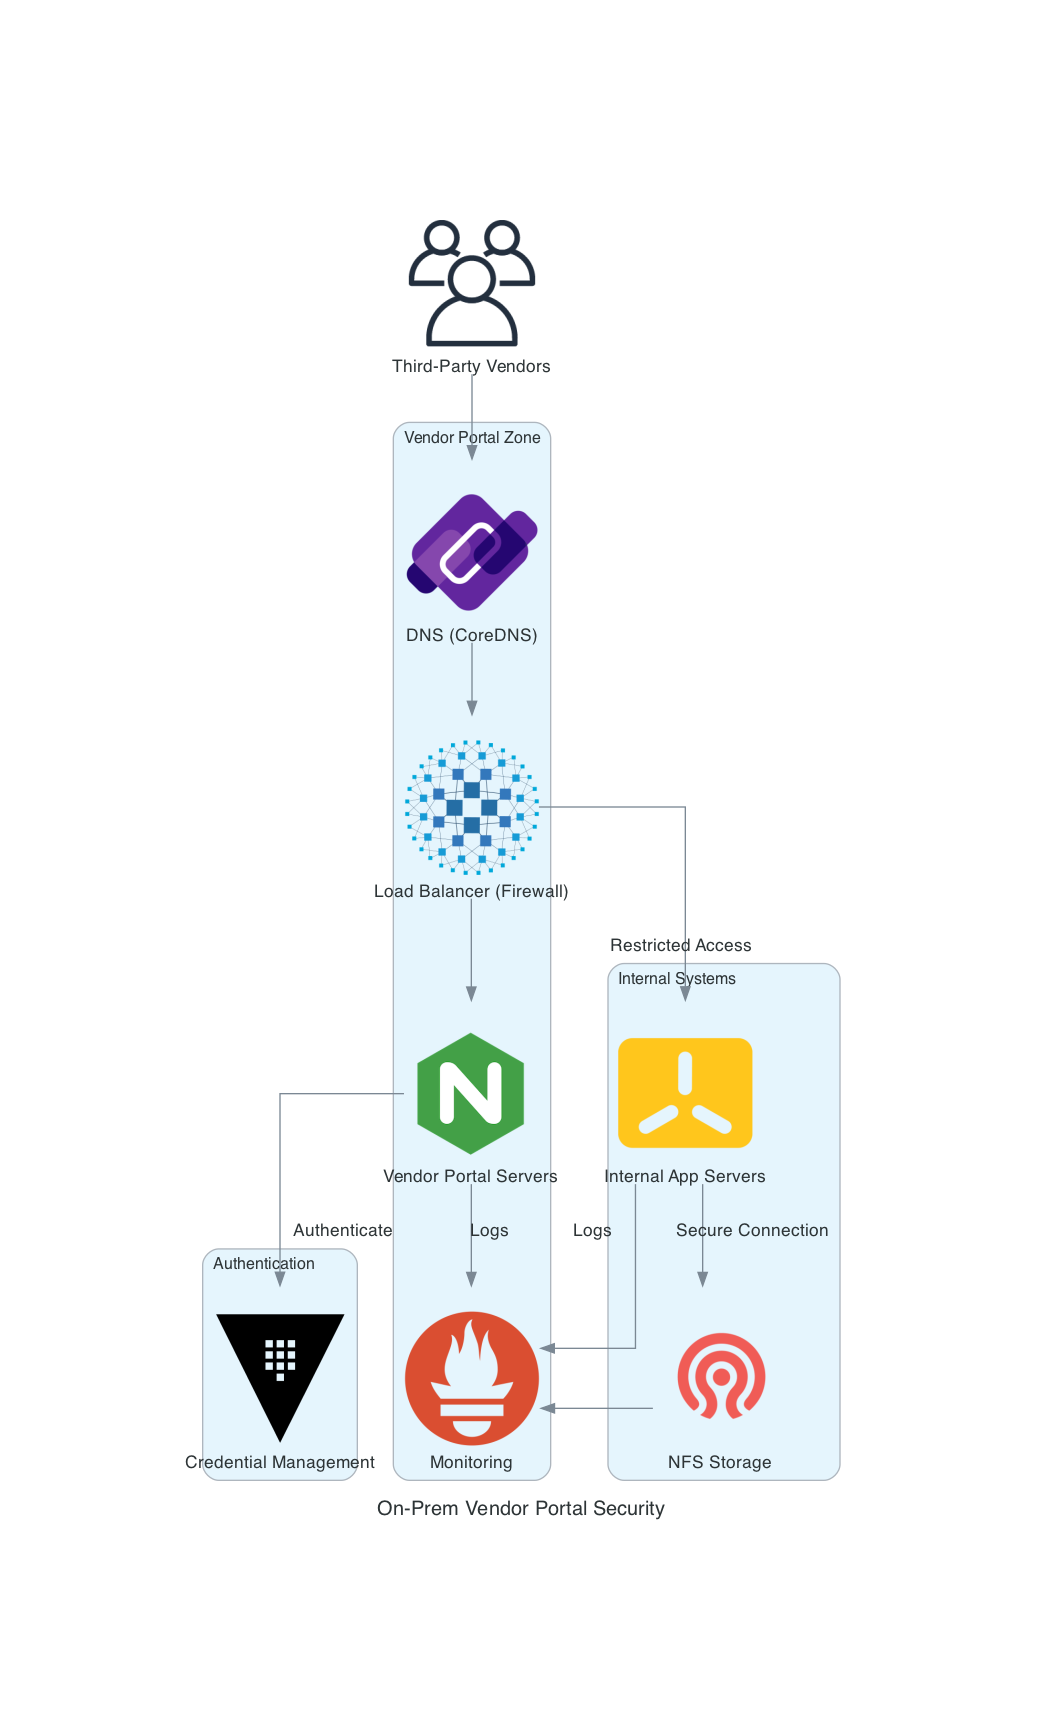

In [30]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem Vendor Portal Security", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_vendor_portal_security"):

    # External Users (Third-Party Vendors)
    vendors = Users("Third-Party Vendors")

    # Vendor Portal Zone
    with Cluster("Vendor Portal Zone"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer (Firewall)")
        web_servers = Nginx("Vendor Portal Servers")
        monitoring = Prometheus("Monitoring")
        
        # Traffic flow
        vendors >> dns >> lb >> web_servers
        web_servers >> Edge(label="Logs") >> monitoring

    # Authentication Layer
    with Cluster("Authentication"):
        vault = Vault("Credential Management")
        web_servers >> Edge(label="Authenticate") >> vault

    # Internal Systems (Isolated)
    with Cluster("Internal Systems"):
        app_servers = Kubernetes("Internal App Servers")
        storage = NetworkFileSystem("NFS Storage")
        lb >> Edge(label="Restricted Access") >> app_servers  # No direct web server access
        app_servers >> Edge(label="Secure Connection") >> storage

        # Internal monitoring
        app_servers >> Edge(label="Logs") >> monitoring
        storage >> Edge(label="Logs") >> monitoring

# Display in Jupyter
image_path = "cyberarch/onprem_vendor_portal_security.png"
display(Image(filename=image_path))

### Build Defense in Depth Archtiecture to address this issue

#### Defense in Depth (DiD) - On-Premises


| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Network Segmentation & Firewalls | Between DMZ and internal tiers                   | Limits lateral movement; isolates breach impact (e.g., Target’s vendor portal flaw).                  |
| 2. Endpoint Hardening           | Web servers (Nginx), Kubernetes nodes            | Reduces vulnerabilities; minimizes attack surface on on-prem systems.                                 |
| 3. Intrusion Detection (IDS) & Logging | DMZ traffic (Prometheus), internal traffic       | Detects anomalies; logs feed into Grafana for analysis (e.g., missed in Equifax).                    |
| 4. Data Encryption in Transit   | TLS between LB→Web, Web→App, App→NFS            | Prevents sniffing; protects data across on-prem network segments.                                     |
| 5. Patch Management & Vulnerability Scans | Regular scans on Nginx, Kubernetes, NFS         | Identifies CVEs; ensures timely updates on on-prem infrastructure.                                    |



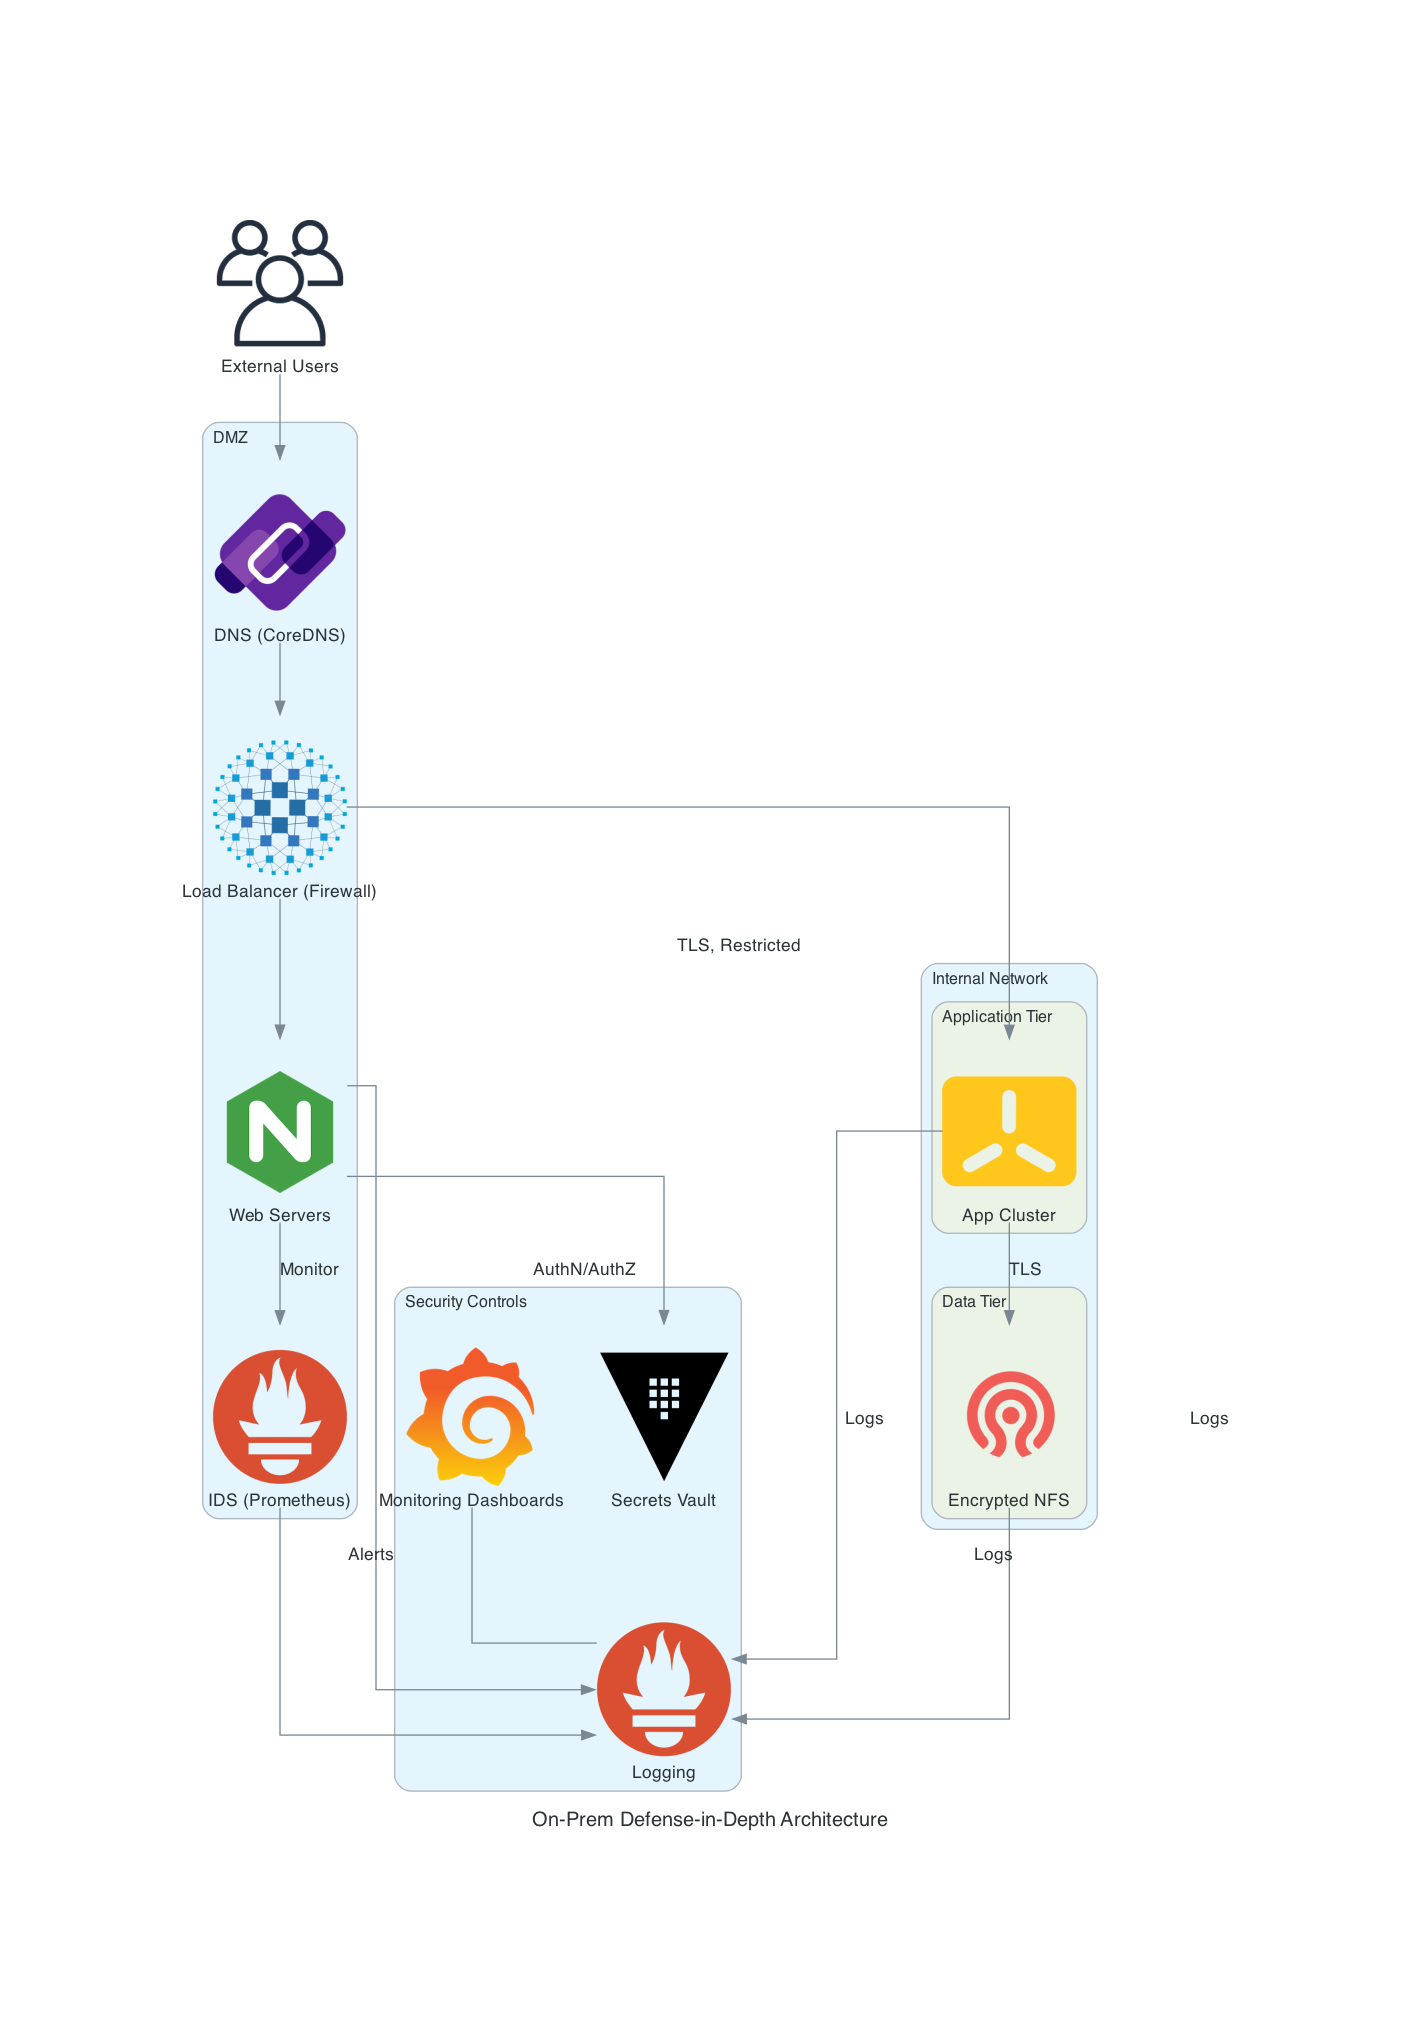

In [20]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem Defense-in-Depth Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_did"):

    # External Users
    users = Users("External Users")

    # DMZ Layer
    with Cluster("DMZ"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer (Firewall)")
        web_servers = Nginx("Web Servers")
        ids = Prometheus("IDS (Prometheus)")
        
        users >> dns >> lb >> web_servers
        web_servers >> Edge(label="Monitor") >> ids

    # Security Control Layer
    with Cluster("Security Controls"):
        vault = Vault("Secrets Vault")
        monitoring = Grafana("Monitoring Dashboards") - Prometheus("Logging")
        
        web_servers >> Edge(label="AuthN/AuthZ") >> vault
        web_servers >> Edge(label="Logs") >> monitoring
        ids >> Edge(label="Alerts") >> monitoring

    # Internal Network
    with Cluster("Internal Network"):
        with Cluster("Application Tier"):
            k8s = Kubernetes("App Cluster")
            lb >> Edge(label="TLS, Restricted") >> k8s

        with Cluster("Data Tier"):
            nfs = NetworkFileSystem("Encrypted NFS")
            k8s >> Edge(label="TLS") >> nfs

        k8s >> Edge(label="Logs") >> monitoring
        nfs >> Edge(label="Logs") >> monitoring

# Display in Jupyter
image_path = "cyberarch/onprem_did.png"
display(Image(filename=image_path))



#### Zero Trust Architecture (ZTA) - On-Premises

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Identity Verification & MFA  | Identity Gateway (Nginx Proxy, Vault)            | Ensures strong authentication; prevents credential theft (e.g., Target’s phishing).                   |
| 2. Microsegmentation            | Between App and Data segments                    | Limits breach scope; requires separate verification (e.g., unlike Target’s flat network).             |
| 3. Behavioral Monitoring & Analytics | All traffic (Prometheus, Grafana)               | Detects anomalies in real-time; addresses Equifax’s detection delay.                                  |
| 4. Encrypted Communication      | TLS across Proxy→App, App→NFS                   | Protects data; prevents interception on on-prem networks.                                             |
| 5. Least Privilege Access Policies | Vault and Proxy for all access                  | Minimizes permissions; stops over-privileged access (e.g., Target’s vendor issue).                    |


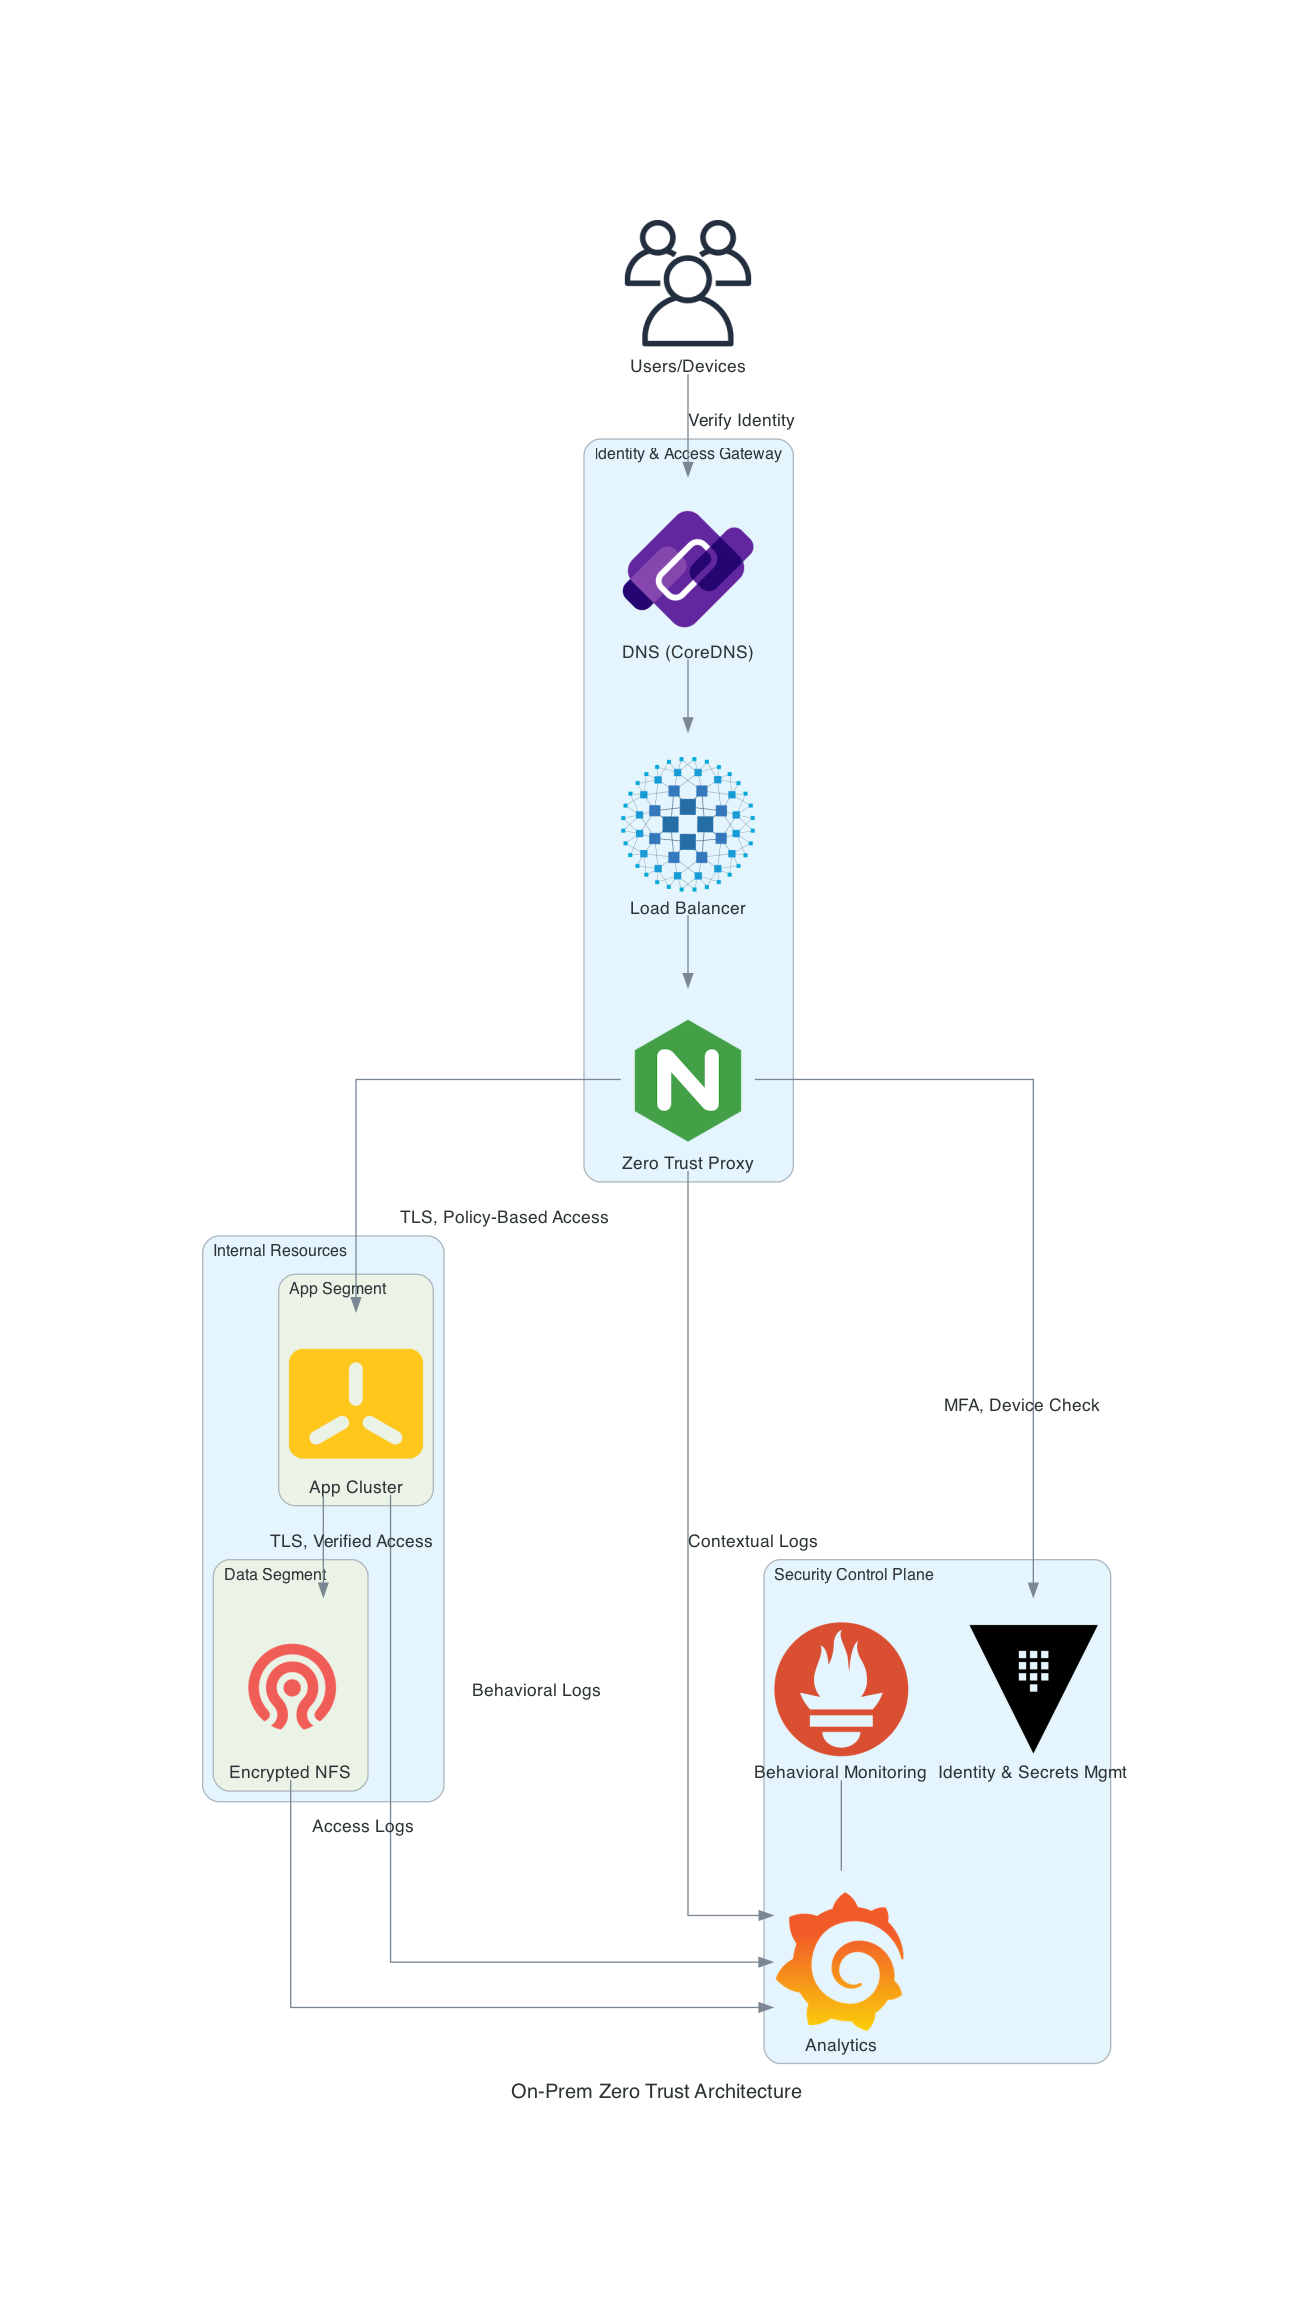

In [22]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem Zero Trust Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_zta"):

    # External Entities
    users = Users("Users/Devices")

    # Identity & Access Gateway
    with Cluster("Identity & Access Gateway"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer")
        proxy = Nginx("Zero Trust Proxy")
        
        users >> Edge(label="Verify Identity") >> dns >> lb >> proxy

    # Security Control Plane
    with Cluster("Security Control Plane"):
        vault = Vault("Identity & Secrets Mgmt")
        monitoring = Prometheus("Behavioral Monitoring") - Grafana("Analytics")
        
        proxy >> Edge(label="MFA, Device Check") >> vault
        proxy >> Edge(label="Contextual Logs") >> monitoring

    # Microsegmented Internal Resources
    with Cluster("Internal Resources"):
        with Cluster("App Segment"):
            k8s = Kubernetes("App Cluster")
            proxy >> Edge(label="TLS, Policy-Based Access") >> k8s

        with Cluster("Data Segment"):
            nfs = NetworkFileSystem("Encrypted NFS")
            k8s >> Edge(label="TLS, Verified Access") >> nfs

        k8s >> Edge(label="Behavioral Logs") >> monitoring
        nfs >> Edge(label="Access Logs") >> monitoring

# Display in Jupyter
image_path = "cyberarch/onprem_zta.png"
display(Image(filename=image_path))


#### Adaptive Security Architecture (ASA) - On-Premises
**Goal**: Dynamically adapt controls to evolving threats in real-time.

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Dynamic Threat Filtering     | Adaptive Perimeter (Haproxy, Nginx Proxy)        | Adjusts rules based on threat intel; blocks attacks proactively (e.g., Target’s phishing).            |
| 2. Behavioral Analytics         | Security Engine (Prometheus, Grafana)            | Detects anomalies with analytics; prevents prolonged breaches (e.g., Equifax’s 76 days).              |
| 3. Automated Policy Updates     | Vault, Kubernetes, Proxy                         | Dynamically adjusts access; reduces delays in response (e.g., Target’s vendor privilege issue).       |
| 4. Encrypted Data Channels      | TLS across Proxy→App, App→NFS                   | Ensures confidentiality; adapts encryption based on threat level.                                     |
| 5. Continuous Monitoring & Feedback | All tiers (Monitoring)                          | Loops insights back to adjust defenses; ensures real-time adaptation on-prem.                         |



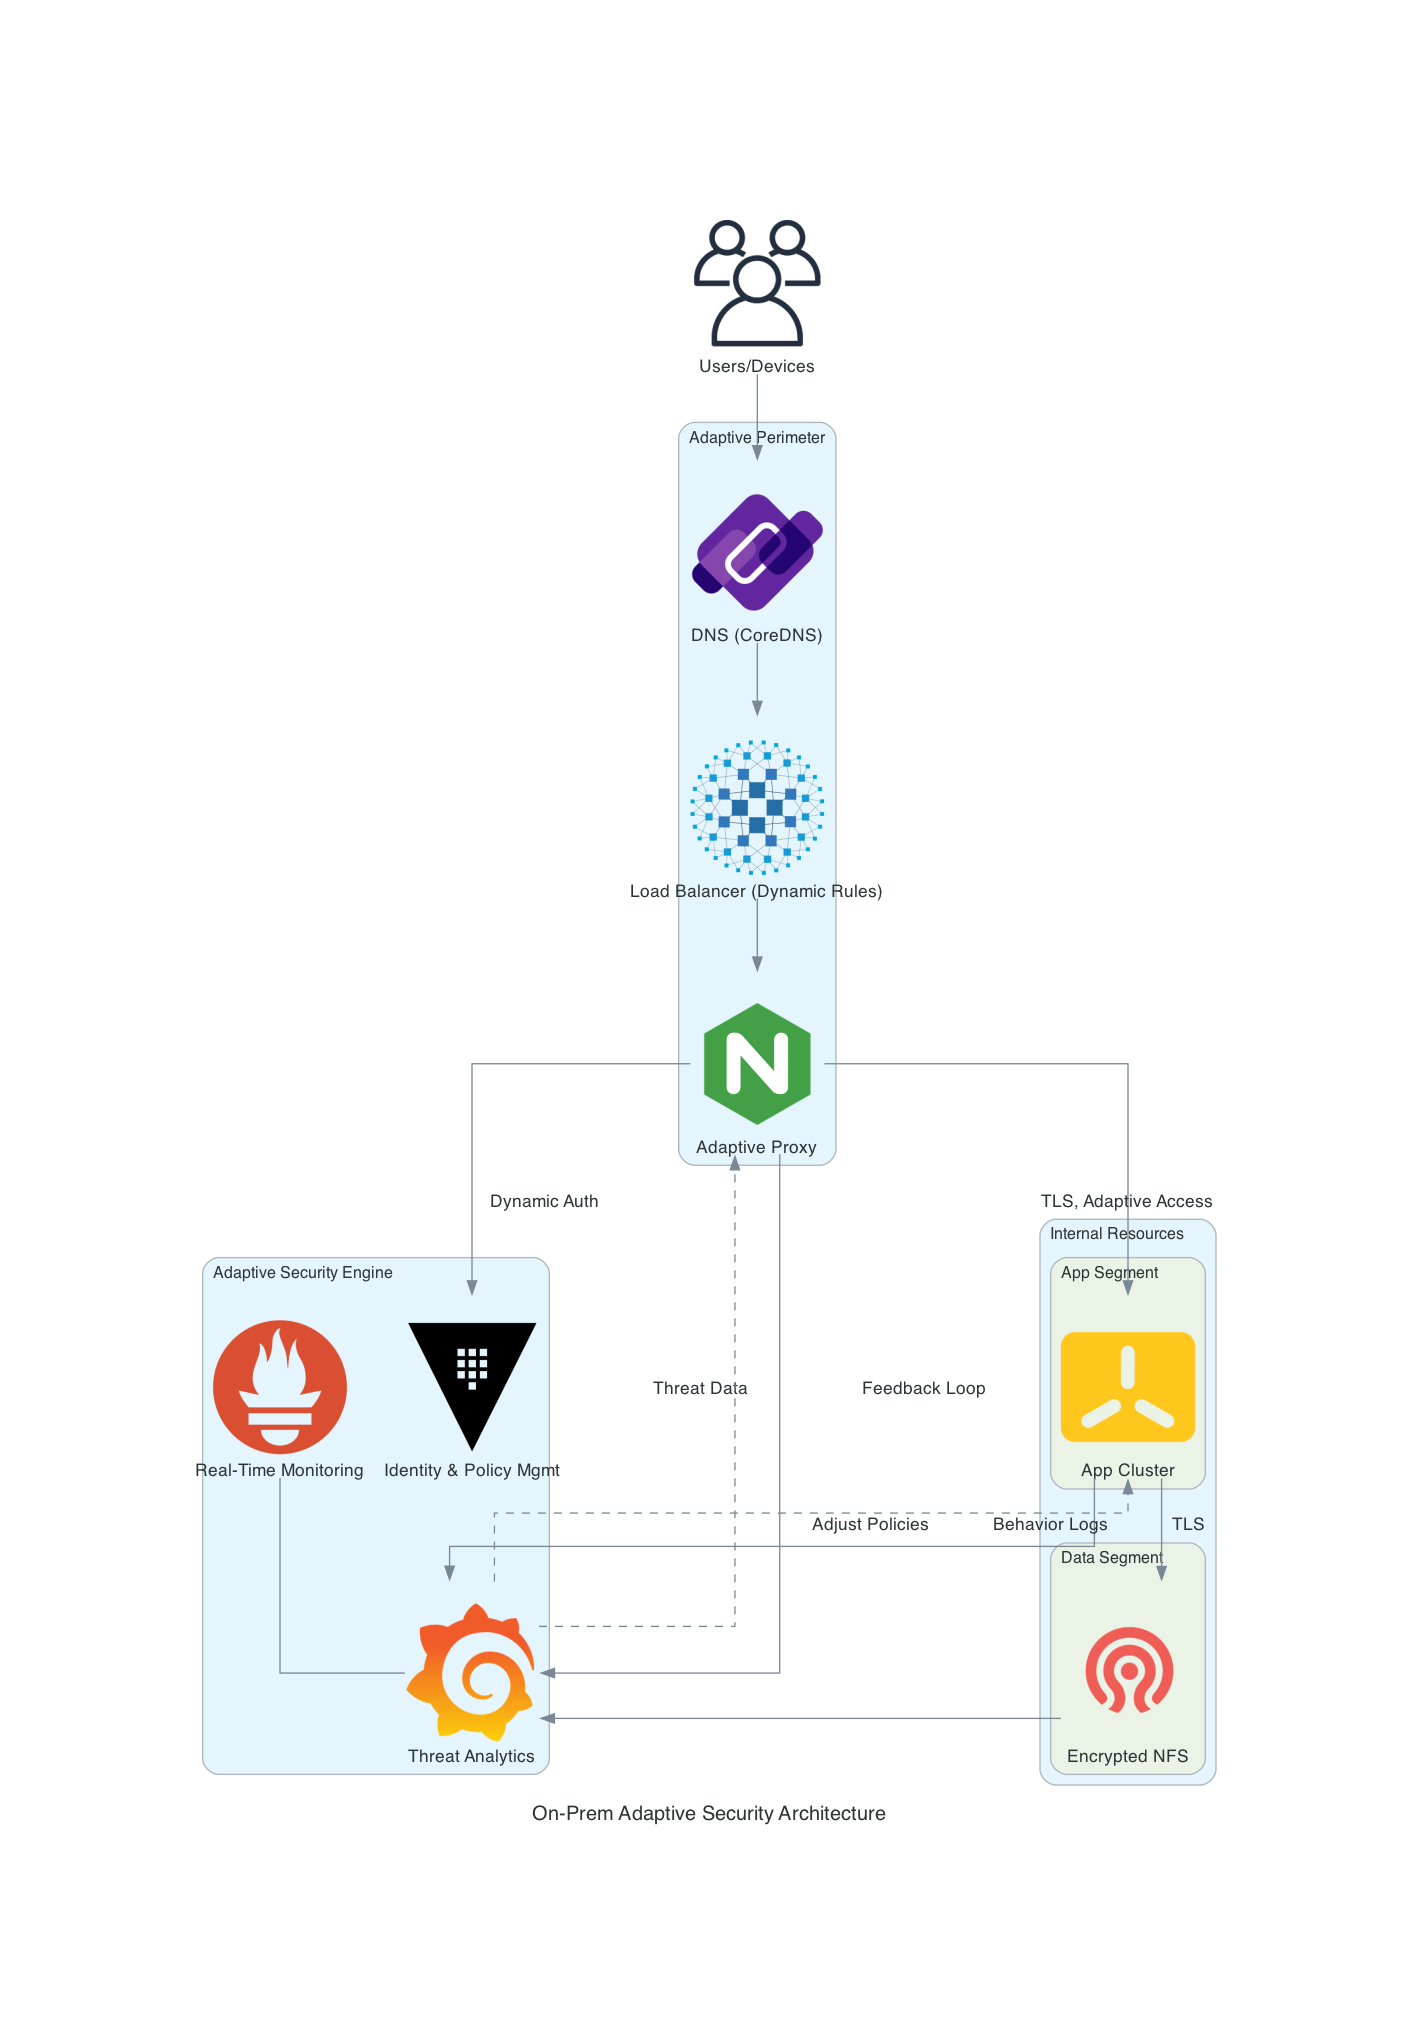

In [24]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem Adaptive Security Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_asa"):

    # External Entities
    users = Users("Users/Devices")

    # Adaptive Perimeter
    with Cluster("Adaptive Perimeter"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer (Dynamic Rules)")
        proxy = Nginx("Adaptive Proxy")
        
        users >> dns >> lb >> proxy

    # Adaptive Security Engine
    with Cluster("Adaptive Security Engine"):
        vault = Vault("Identity & Policy Mgmt")
        monitoring = Prometheus("Real-Time Monitoring") - Grafana("Threat Analytics")
        
        proxy >> Edge(label="Dynamic Auth") >> vault
        proxy >> Edge(label="Threat Data") >> monitoring
        monitoring >> Edge(label="Feedback Loop", style="dashed") >> proxy

    # Segmented Internal Resources
    with Cluster("Internal Resources"):
        with Cluster("App Segment"):
            k8s = Kubernetes("App Cluster")
            proxy >> Edge(label="TLS, Adaptive Access") >> k8s

        with Cluster("Data Segment"):
            nfs = NetworkFileSystem("Encrypted NFS")
            k8s >> Edge(label="TLS") >> nfs

        k8s >> Edge(label="Behavior Logs") >> monitoring
        nfs >> Edge(label="Access Logs") >> monitoring
        monitoring >> Edge(label="Adjust Policies", style="dashed") >> k8s

# Display in Jupyter
image_path = "cyberarch/onprem_asa.png"
display(Image(filename=image_path))


### Defense in Depth Controls

**Goal**: Multiple, independent layers of security to contain or mitigate breaches if one layer fails.

| **Control**                     | **Where It Applies**                              | **Reason**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Network Segmentation & Firewalls | Between DMZ and internal tiers; between App and Data tiers | Limits attacker lateral movement; if the DMZ is compromised (e.g., via phishing), internal systems remain isolated. |
| 2. Endpoint Hardening           | Web servers (Nginx), App servers (EC2), Kubernetes nodes | Minimizes OS vulnerabilities; reduces attack surface by disabling unnecessary services and hardening configurations. |
| 3. Intrusion Detection (IDS) & Logging | DMZ inbound traffic (Prometheus), internal app/db traffic | Detects suspicious patterns (e.g., unusual vendor access); logs feed into SIEM (Cloudwatch/Grafana) for correlation. |
| 4. Data Encryption in Transit   | TLS between LB→Web, Web→App, App→DB            | Prevents sniffing or tampering; ensures data remains confidential even if network traffic is intercepted. |
| 5. Patch Management & Vulnerability Scans | Regular scans on Nginx, EC2, Kubernetes, S3    | Identifies and remediates known CVEs (e.g., Apache Struts in Equifax); reduces exploit windows proactively. |


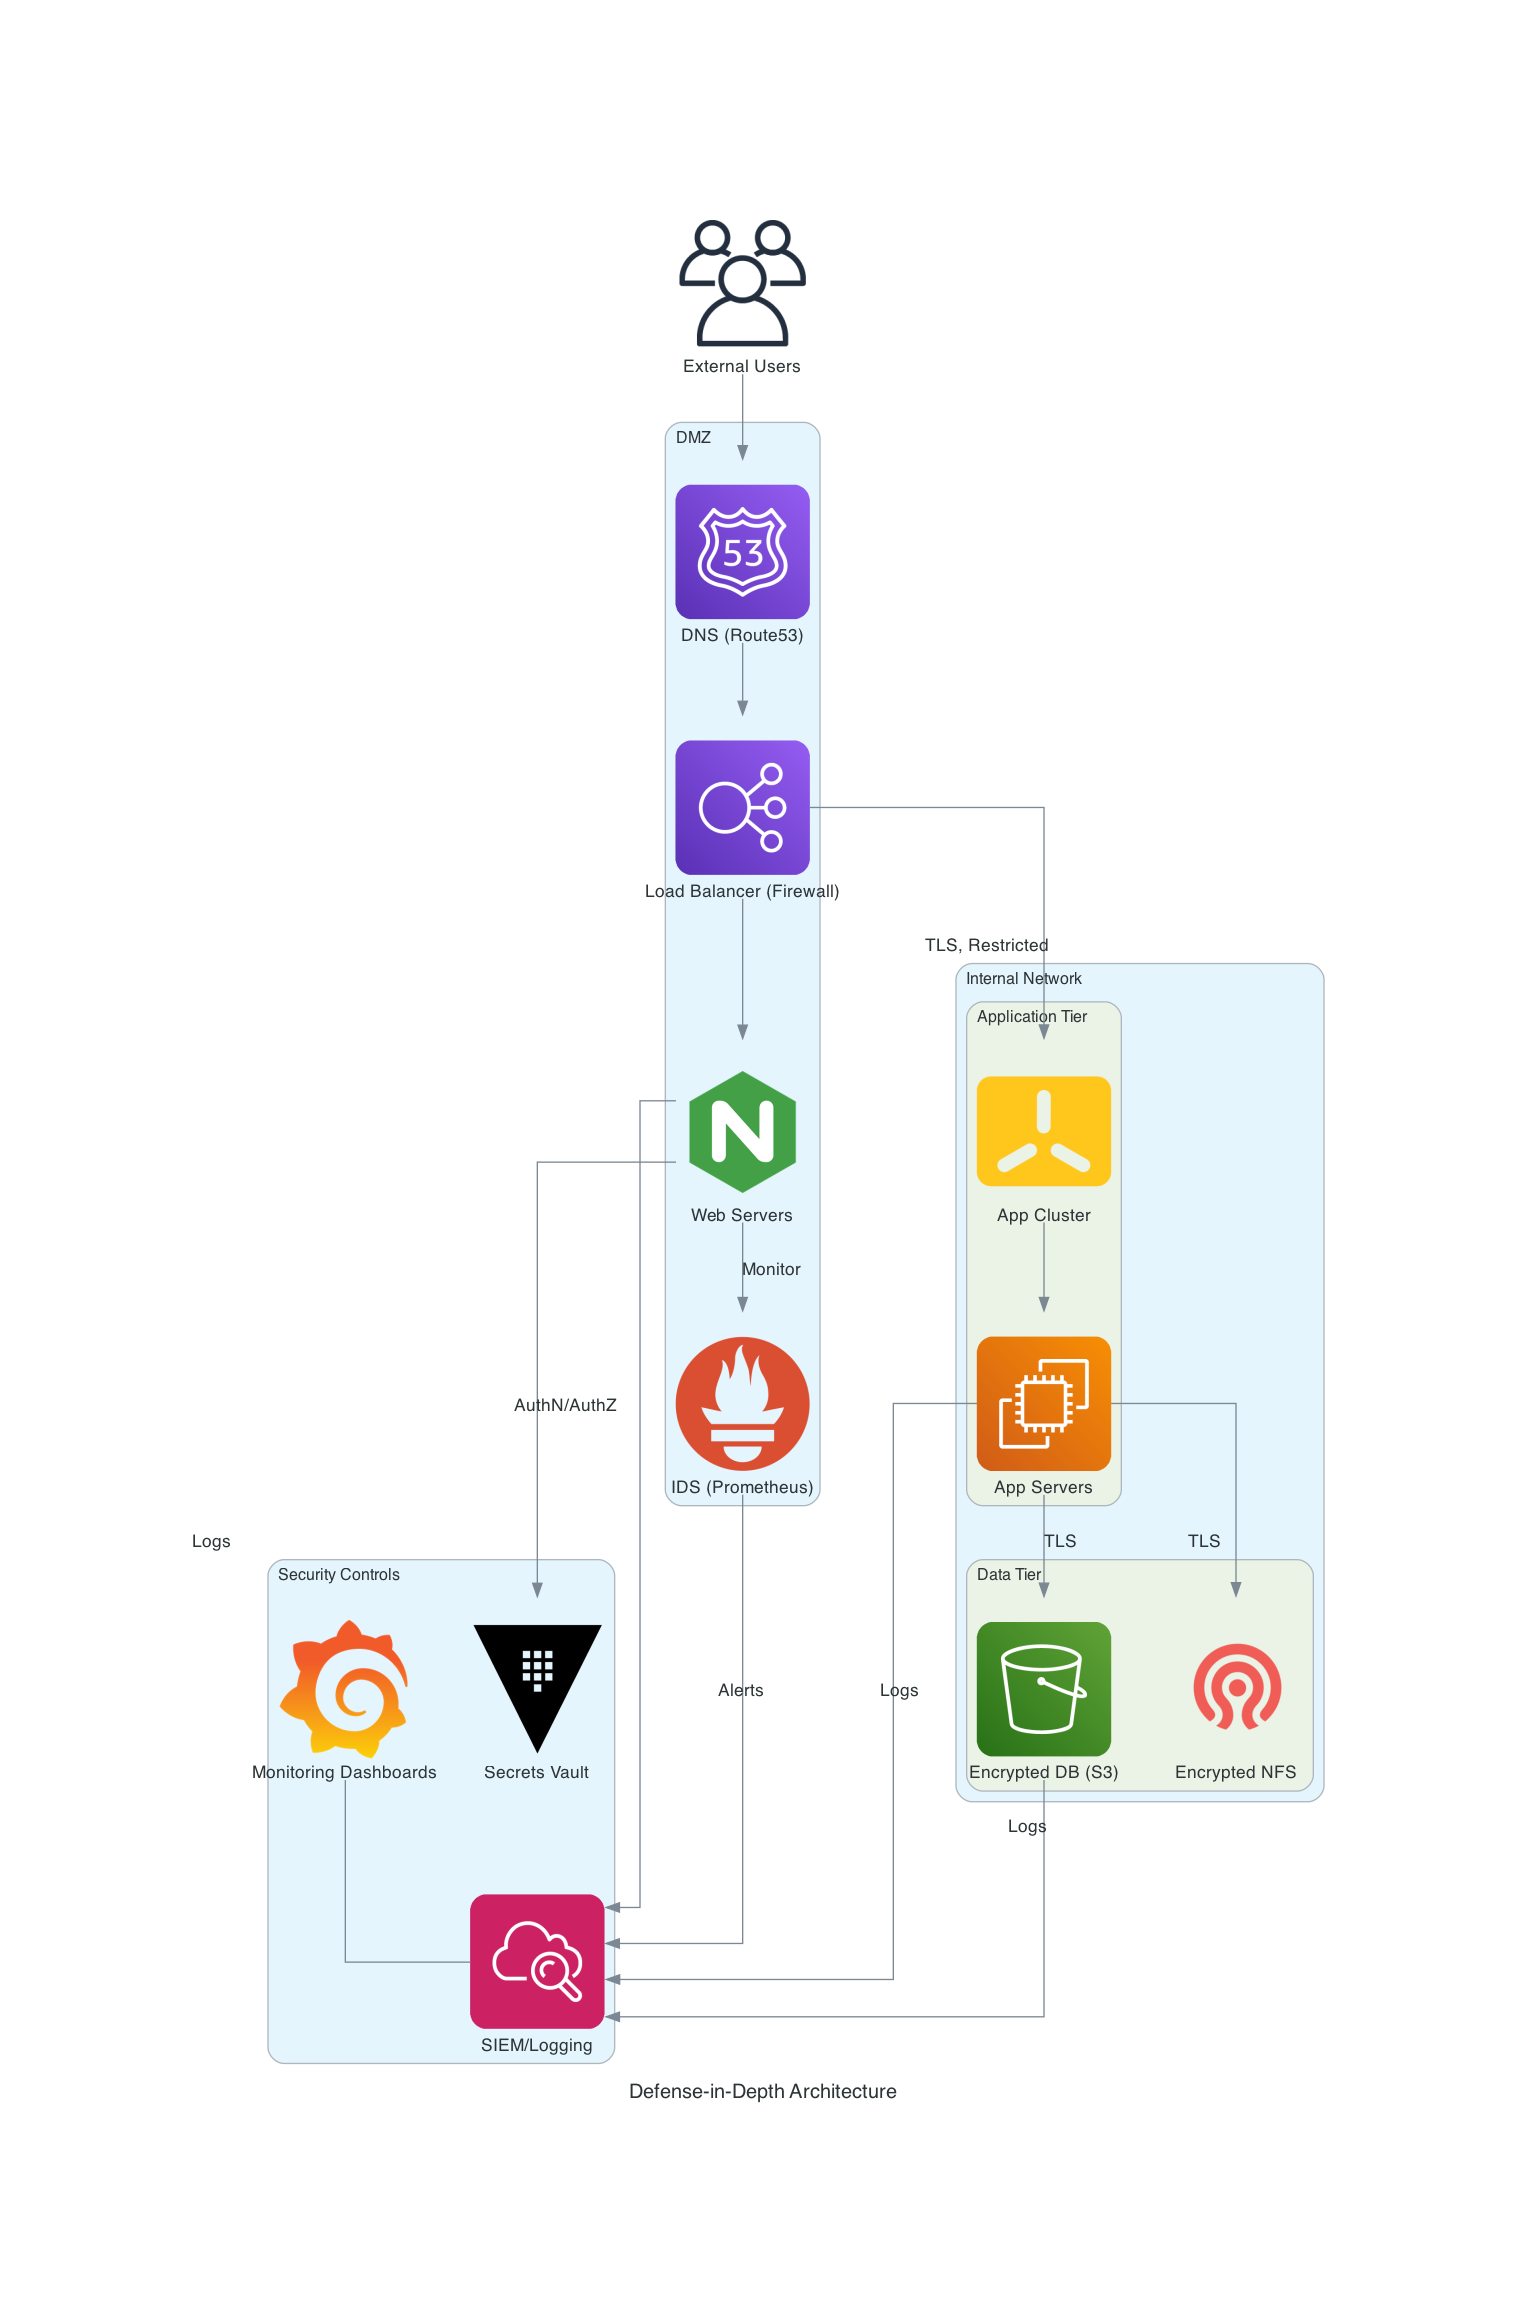

In [17]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from diagrams.aws.compute import EC2
from diagrams.aws.network import ElasticLoadBalancing as ElasticLoadBalancer, Route53
from diagrams.aws.storage import S3 as SimpleStorageService
from diagrams.aws.management import Cloudwatch
from IPython.display import Image

# Create output directory for diagrams if it doesn't exist
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("Defense-in-Depth Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/defense_in_depth_architecture"):

    # External Users (e.g., Vendors, Customers)
    users = Users("External Users")

    # DMZ Layer
    with Cluster("DMZ"):
        dns = Route53("DNS (Route53)")
        lb = ElasticLoadBalancer("Load Balancer (Firewall)")
        web_servers = Nginx("Web Servers")
        ids = Prometheus("IDS (Prometheus)")
        
        # Traffic flow with IDS monitoring
        users >> dns >> lb >> web_servers
        web_servers >> Edge(label="Monitor") >> ids

    # Security Control Layer
    with Cluster("Security Controls"):
        vault = Vault("Secrets Vault")
        monitoring = Grafana("Monitoring Dashboards") - Cloudwatch("SIEM/Logging")
        
        # Web servers integrate with security controls
        web_servers >> Edge(label="AuthN/AuthZ") >> vault
        web_servers >> Edge(label="Logs") >> monitoring
        ids >> Edge(label="Alerts") >> monitoring

    # Internal Network (Segmented)
    with Cluster("Internal Network"):
        # Application Tier
        with Cluster("Application Tier"):
            k8s = Kubernetes("App Cluster")
            app_servers = EC2("App Servers")
            lb >> Edge(label="TLS, Restricted") >> k8s
            k8s >> app_servers

        # Data Tier
        with Cluster("Data Tier"):
            db = SimpleStorageService("Encrypted DB (S3)")
            nfs = NetworkFileSystem("Encrypted NFS")
            app_servers >> Edge(label="TLS") >> db
            app_servers >> Edge(label="TLS") >> nfs

        # Internal Monitoring
        app_servers >> Edge(label="Logs") >> monitoring
        db >> Edge(label="Logs") >> monitoring

# Display the generated image in Jupyter
image_path = "cyberarch/defense_in_depth_architecture.png"
display(Image(filename=image_path))

### Zero Trust Arhitecture Controls

**Goal**: Enforce continuous verification of identity, device, and context, assuming no trust by default, to prevent unauthorized access and lateral movement.

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Identity Verification & MFA  | Identity Gateway (Nginx Proxy, Vault)            | Ensures every user/device is authenticated with multi-factor authentication (MFA); prevents credential theft (e.g., Target breach entry). |
| 2. Microsegmentation            | Between App Segment and Data Segment; within tiers | Limits blast radius; even if one resource is compromised, others require separate verification (unlike Target’s flat network). |
| 3. Behavioral Monitoring & Analytics | All traffic (Prometheus, Grafana, Cloudwatch)    | Detects anomalies (e.g., unusual access patterns) in real-time; flags potential breaches missed in Equifax’s 76-day delay. |
| 4. Encrypted Communication      | TLS across Proxy→App, App→DB, App→NFS           | Protects data in transit; prevents interception or tampering even if network is breached.             |
| 5. Least Privilege Access Policies | Vault and Proxy for all resource access          | Grants minimal access based on context (e.g., role, device health); stops over-privileged credentials (Target vendor issue). |


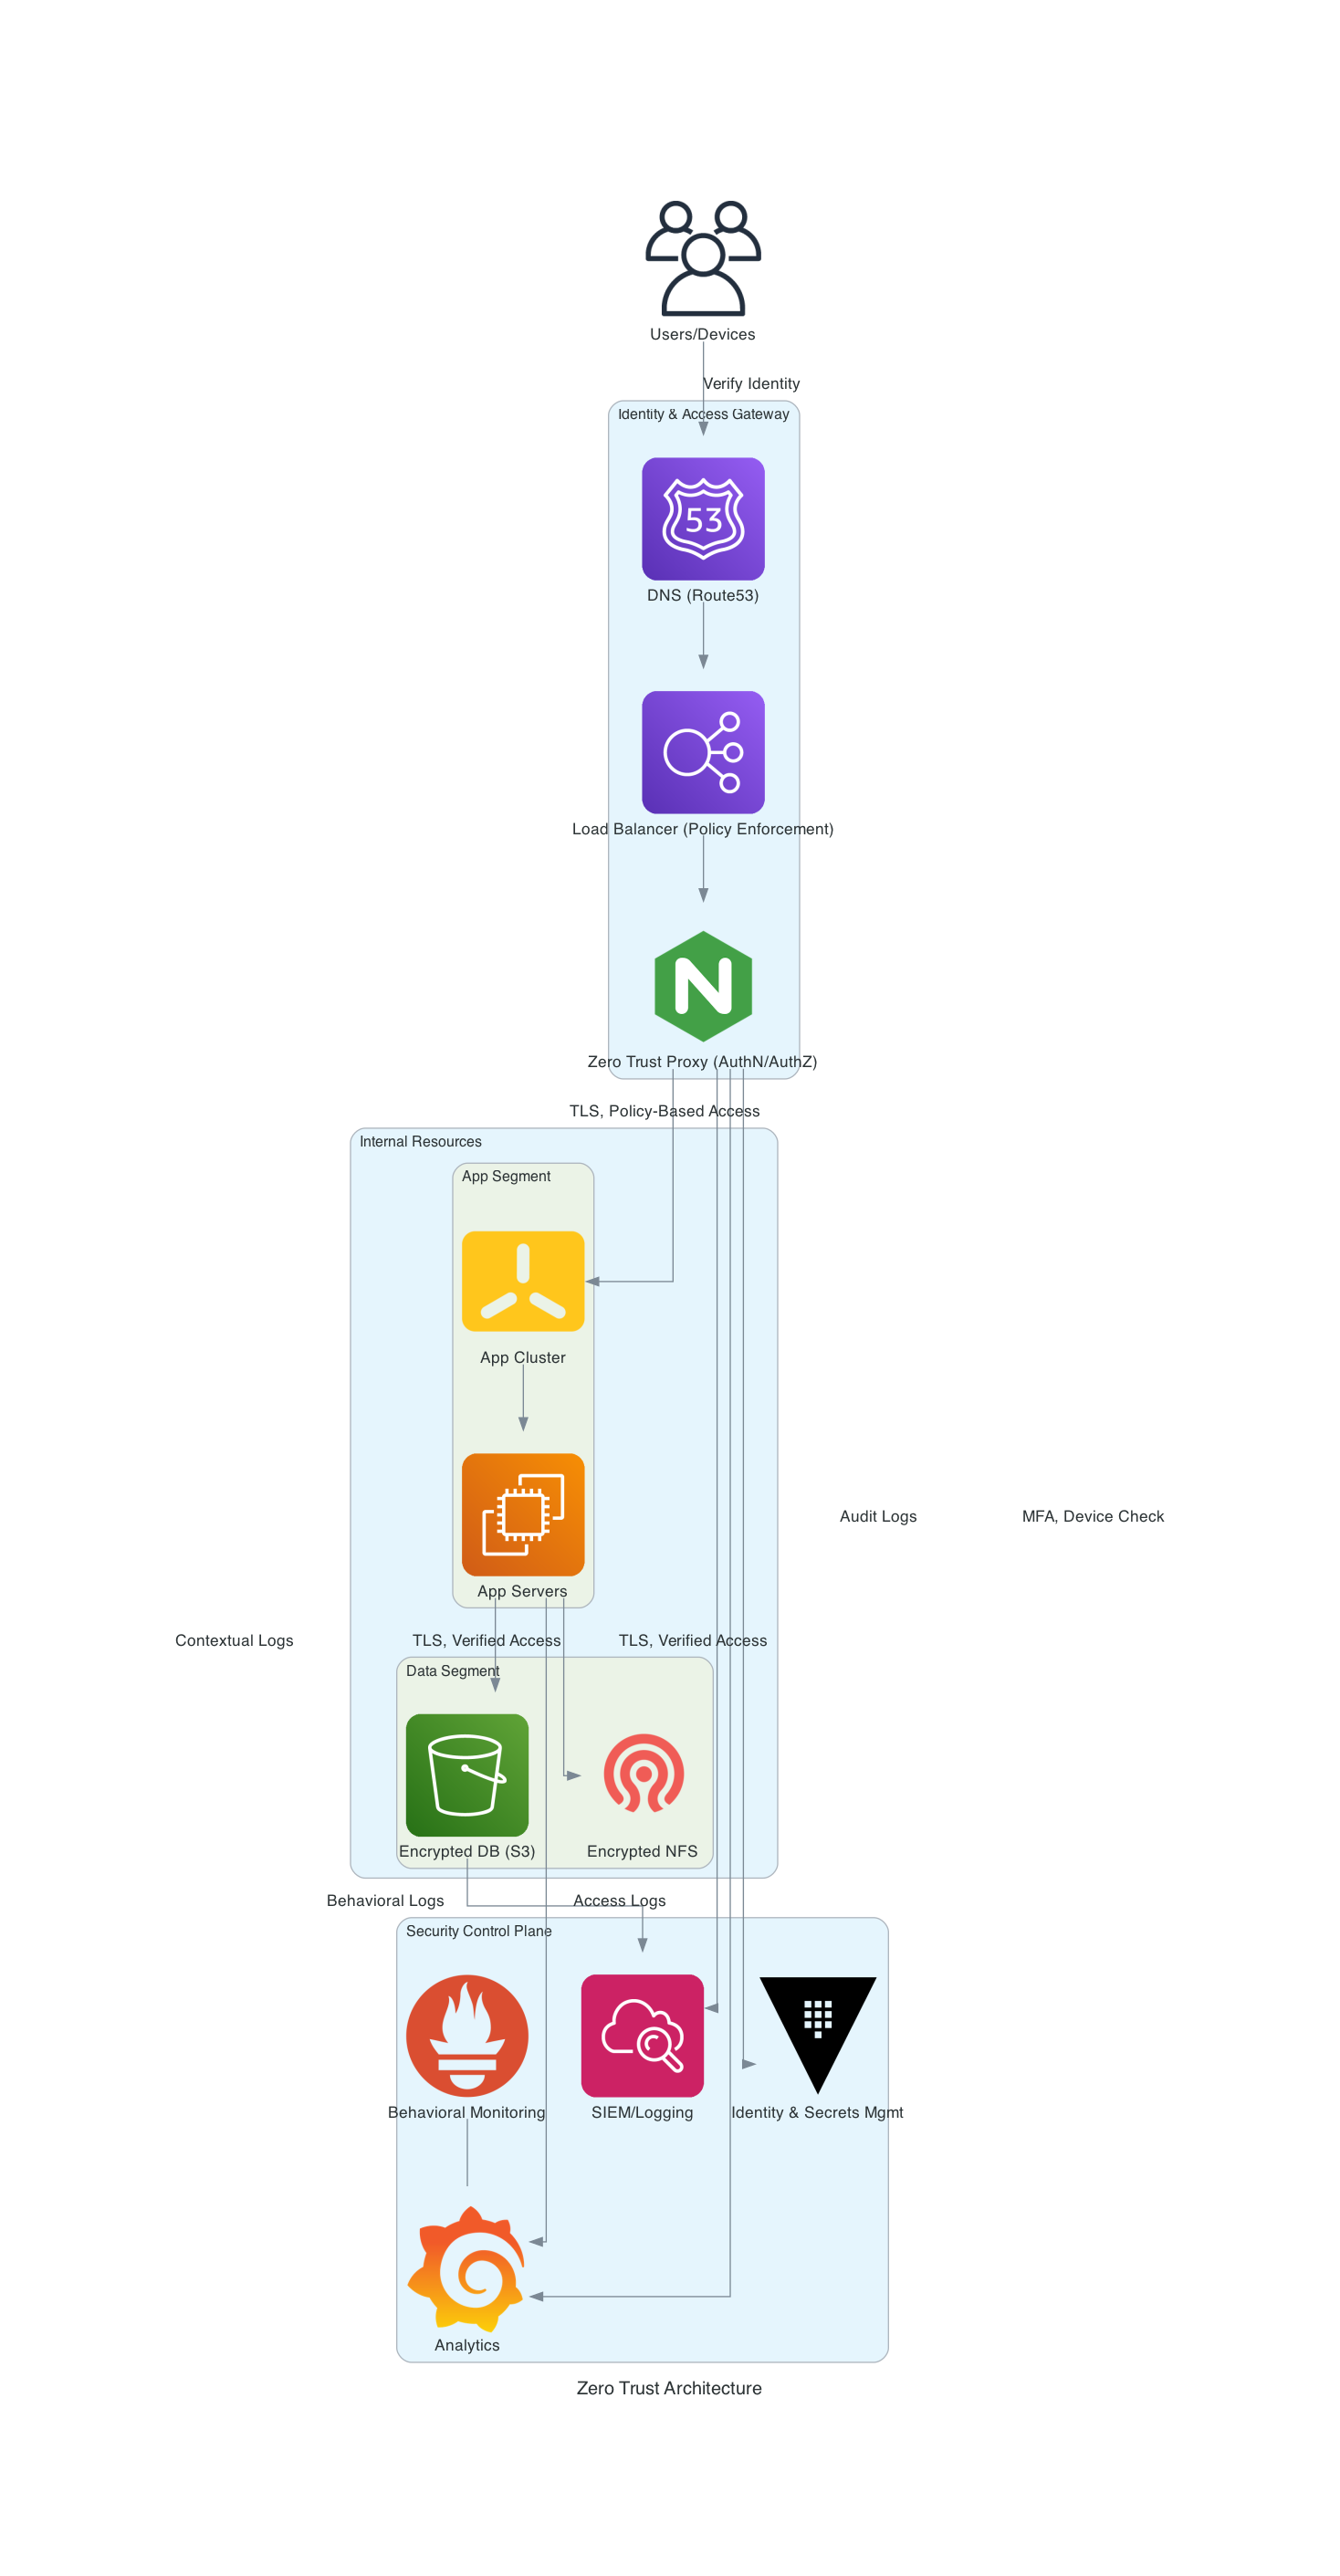

In [18]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from diagrams.aws.compute import EC2
from diagrams.aws.network import ElasticLoadBalancing as ElasticLoadBalancer, Route53
from diagrams.aws.storage import S3 as SimpleStorageService
from diagrams.aws.management import Cloudwatch
from IPython.display import Image

# Create output directory for diagrams if it doesn't exist
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("Zero Trust Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/zero_trust_architecture"):

    # External Entities (Users/Devices)
    users = Users("Users/Devices")

    # Perimeter Security (Identity Gateway)
    with Cluster("Identity & Access Gateway"):
        dns = Route53("DNS (Route53)")
        lb = ElasticLoadBalancer("Load Balancer (Policy Enforcement)")
        proxy = Nginx("Zero Trust Proxy (AuthN/AuthZ)")
        
        # Traffic flow with continuous verification
        users >> Edge(label="Verify Identity") >> dns >> lb >> proxy

    # Security Control Plane
    with Cluster("Security Control Plane"):
        vault = Vault("Identity & Secrets Mgmt")
        monitoring = Prometheus("Behavioral Monitoring") - Grafana("Analytics")
        siem = Cloudwatch("SIEM/Logging")
        
        # Proxy integrates with control plane
        proxy >> Edge(label="MFA, Device Check") >> vault
        proxy >> Edge(label="Contextual Logs") >> monitoring
        proxy >> Edge(label="Audit Logs") >> siem

    # Microsegmented Internal Resources
    with Cluster("Internal Resources"):
        # Application Tier
        with Cluster("App Segment"):
            k8s = Kubernetes("App Cluster")
            app_servers = EC2("App Servers")
            proxy >> Edge(label="TLS, Policy-Based Access") >> k8s
            k8s >> app_servers

        # Data Tier
        with Cluster("Data Segment"):
            db = SimpleStorageService("Encrypted DB (S3)")
            nfs = NetworkFileSystem("Encrypted NFS")
            app_servers >> Edge(label="TLS, Verified Access") >> db
            app_servers >> Edge(label="TLS, Verified Access") >> nfs

        # Continuous Monitoring
        app_servers >> Edge(label="Behavioral Logs") >> monitoring
        db >> Edge(label="Access Logs") >> siem

# Display the generated image in Jupyter
image_path = "cyberarch/zero_trust_architecture.png"
display(Image(filename=image_path))

#### Adaptive Security Architecture
**Goal**: Dynamically adapt security controls in real-time to evolving threats, minimizing response time and maximizing resilience.

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Dynamic Threat Filtering     | Adaptive Perimeter (LB, Nginx Proxy)             | Adjusts firewall/proxy rules based on real-time threat intel; blocks attacks like Target’s phishing entry proactively. |
| 2. Behavioral Analytics & ML    | Security Engine (Prometheus, Grafana, Cloudwatch)| Detects anomalies (e.g., Equifax’s undetected 76-day breach) using machine learning; predicts and prioritizes risks. |
| 3. Automated Policy Updates     | Vault, Kubernetes, Proxy                         | Updates access policies dynamically (e.g., revoking over-privileged vendor access in Target); reduces manual delays. |
| 4. Encrypted Data Channels      | TLS across Proxy→App, App→DB, App→NFS           | Ensures data integrity/confidentiality; adapts encryption strength based on threat level.              |
| 5. Continuous Monitoring & Feedback | All tiers (Monitoring, SIEM)                    | Provides real-time visibility and loops insights back to adjust defenses; prevents prolonged breaches. |


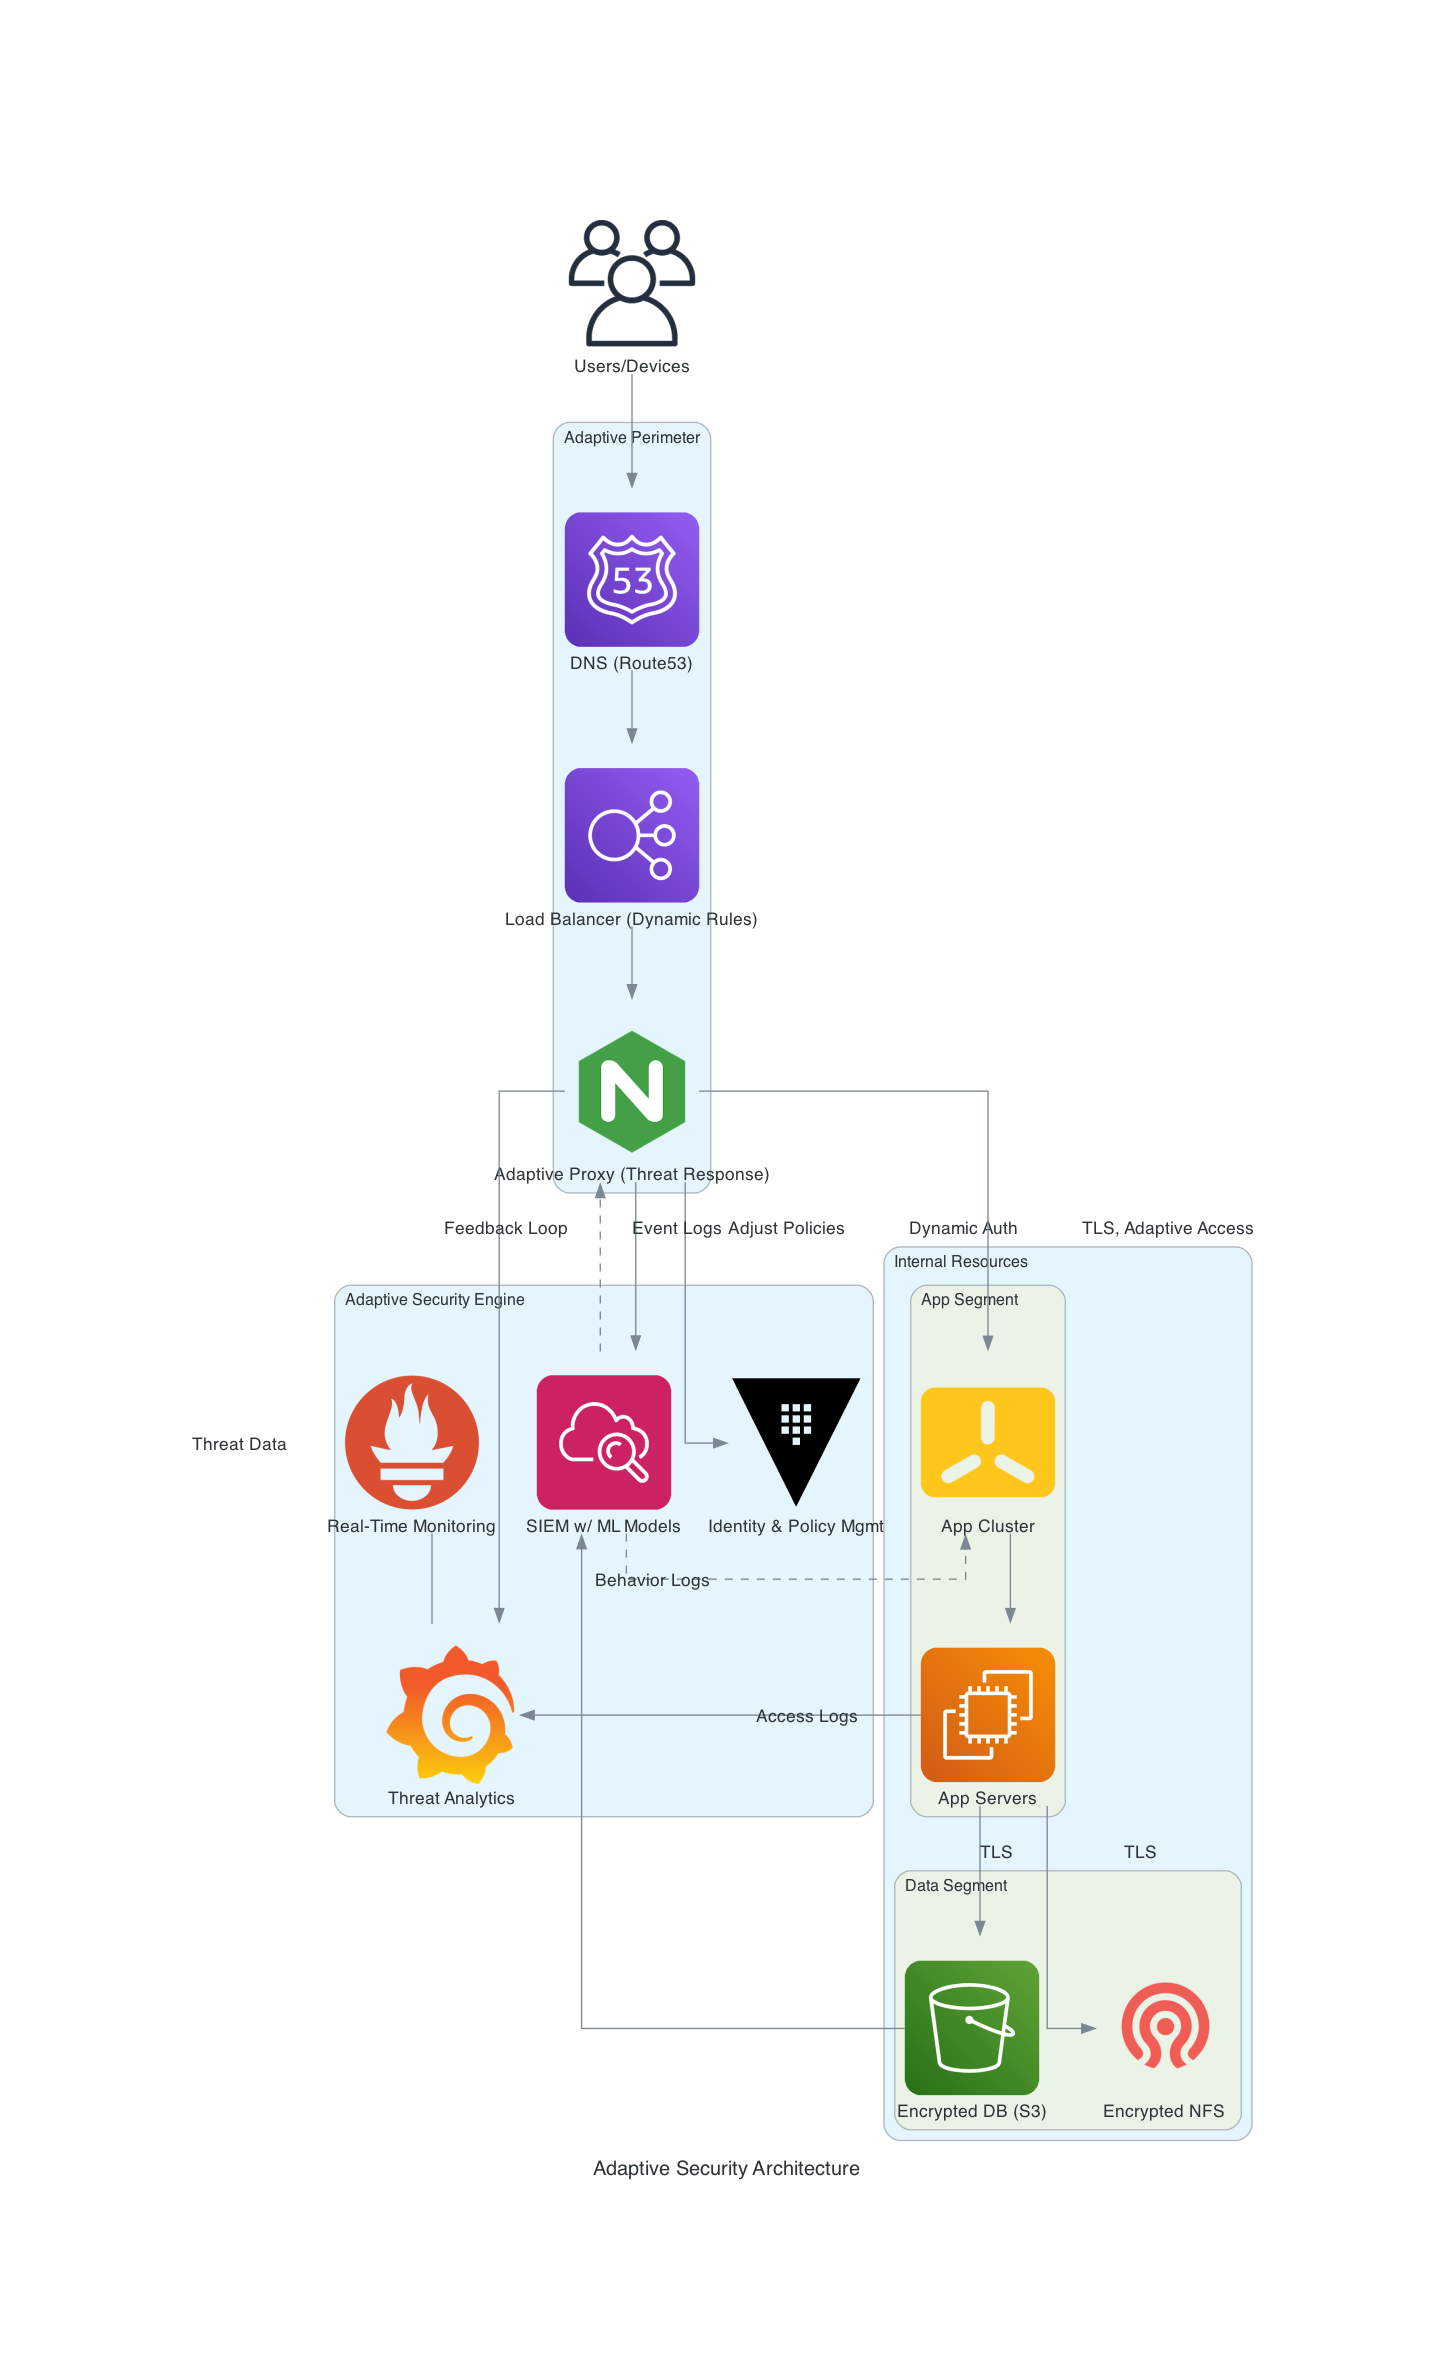

In [19]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from diagrams.aws.compute import EC2
from diagrams.aws.network import ElasticLoadBalancing as ElasticLoadBalancer, Route53
from diagrams.aws.storage import S3 as SimpleStorageService
from diagrams.aws.management import Cloudwatch
from IPython.display import Image

# Create output directory for diagrams if it doesn't exist
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("Adaptive Security Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/adaptive_security_architecture"):

    # External Entities (Users/Devices)
    users = Users("Users/Devices")

    # Adaptive Perimeter
    with Cluster("Adaptive Perimeter"):
        dns = Route53("DNS (Route53)")
        lb = ElasticLoadBalancer("Load Balancer (Dynamic Rules)")
        proxy = Nginx("Adaptive Proxy (Threat Response)")
        
        # Traffic flow with adaptive filtering
        users >> dns >> lb >> proxy

    # Adaptive Security Engine
    with Cluster("Adaptive Security Engine"):
        vault = Vault("Identity & Policy Mgmt")
        monitoring = Prometheus("Real-Time Monitoring") - Grafana("Threat Analytics")
        siem = Cloudwatch("SIEM w/ ML Models")
        
        # Proxy integrates with adaptive engine
        proxy >> Edge(label="Dynamic Auth") >> vault
        proxy >> Edge(label="Threat Data") >> monitoring
        proxy >> Edge(label="Event Logs") >> siem
        siem >> Edge(label="Feedback Loop", style="dashed") >> proxy  # Adaptive response

    # Segmented Internal Resources
    with Cluster("Internal Resources"):
        # Application Tier
        with Cluster("App Segment"):
            k8s = Kubernetes("App Cluster")
            app_servers = EC2("App Servers")
            proxy >> Edge(label="TLS, Adaptive Access") >> k8s
            k8s >> app_servers

        # Data Tier
        with Cluster("Data Segment"):
            db = SimpleStorageService("Encrypted DB (S3)")
            nfs = NetworkFileSystem("Encrypted NFS")
            app_servers >> Edge(label="TLS") >> db
            app_servers >> Edge(label="TLS") >> nfs

        # Continuous Feedback
        app_servers >> Edge(label="Behavior Logs") >> monitoring
        db >> Edge(label="Access Logs") >> siem
        siem >> Edge(label="Adjust Policies", style="dashed") >> k8s  # Dynamic policy updates

# Display the generated image in Jupyter
image_path = "cyberarch/adaptive_security_architecture.png"
display(Image(filename=image_path))

#### Issue-2: Internal Network

- **Description**: Target’s internal network included various segments such as corporate systems, servers, and store-level infrastructure. It relied heavily on Microsoft technologies, including Microsoft System Center Configuration Manager (SCCM) for system updates and virtualization software for managing infrastructure.
- **Role in Breach**: Once inside the network, attackers moved laterally from the vendor portal to other internal systems. They exploited poor network segmentation, which allowed them to access sensitive areas not directly related to the vendor’s purpose.
- **Vulnerability**: The lack of proper network segmentation meant that a breach in one area (e.g., the vendor portal) could lead to unrestricted access across the network. Additionally, publicly available case studies on Microsoft’s website provided attackers with detailed insights into Target’s infrastructure, aiding reconnaissance.


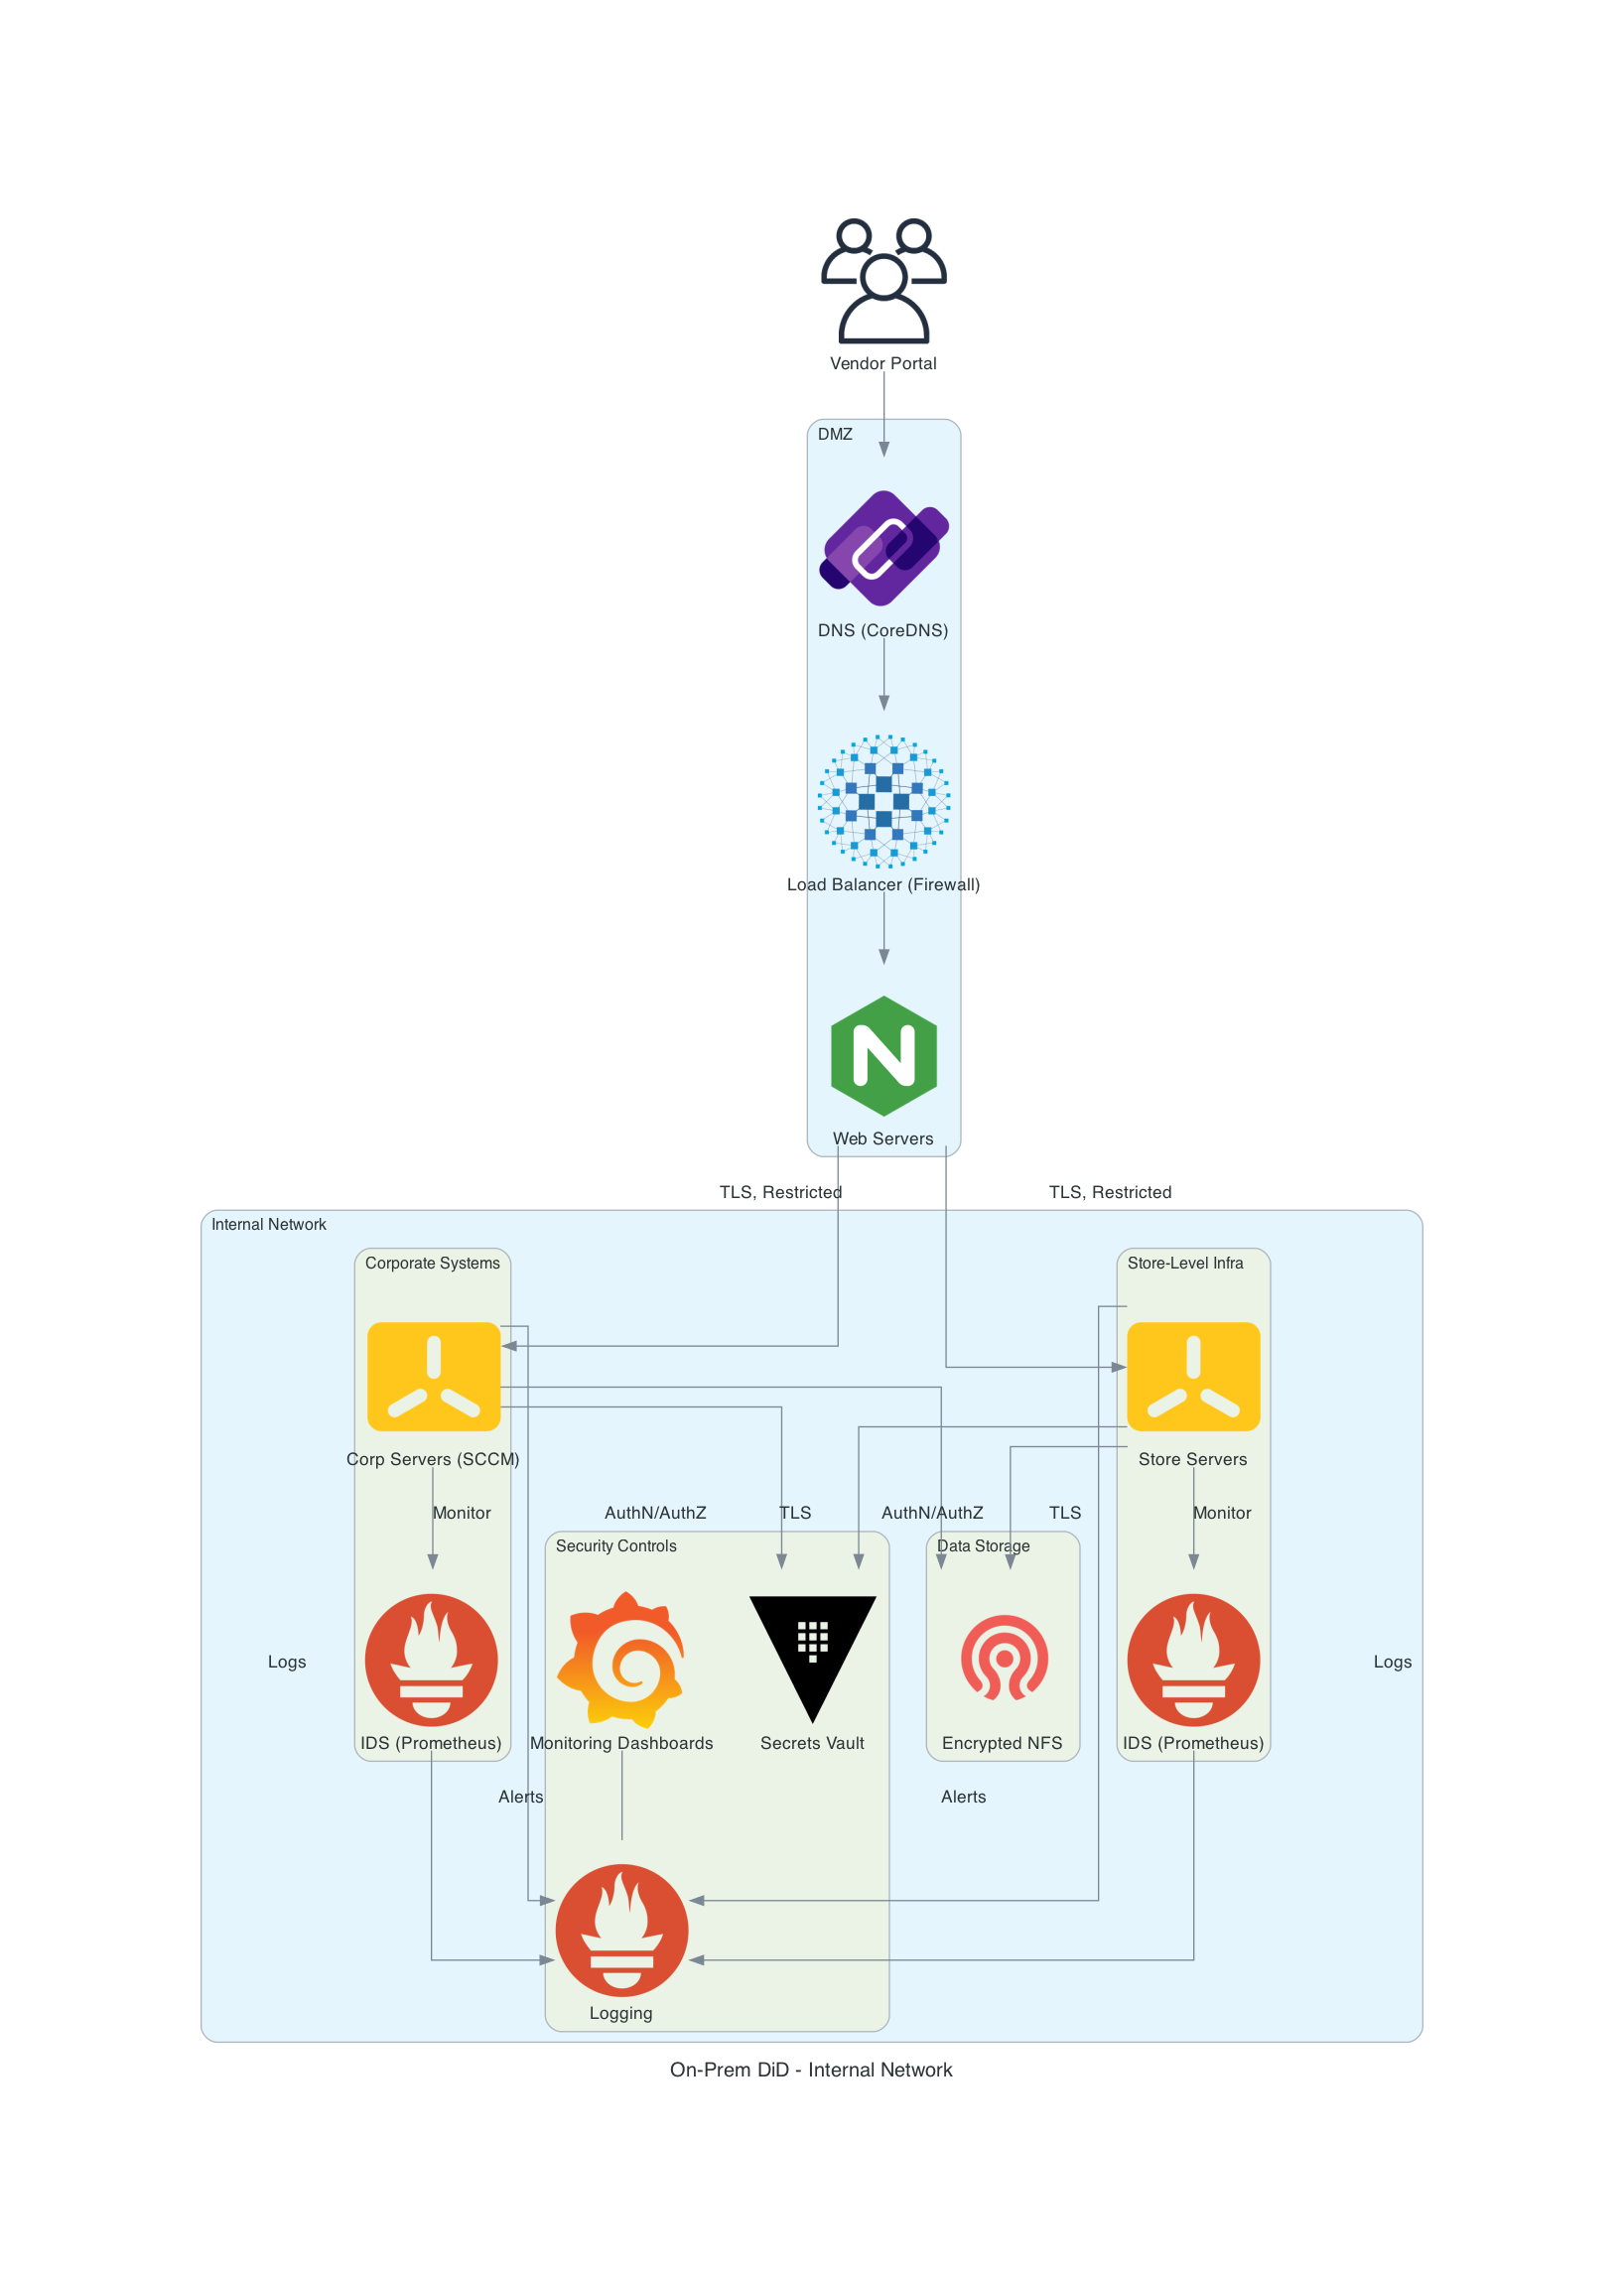

In [25]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem DiD - Internal Network", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_did_internal"):

    # External Users (e.g., Vendor Portal)
    vendors = Users("Vendor Portal")

    # DMZ (Entry Point)
    with Cluster("DMZ"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer (Firewall)")
        web_servers = Nginx("Web Servers")
        vendors >> dns >> lb >> web_servers

    # Segmented Internal Network
    with Cluster("Internal Network"):
        # Corporate Systems Segment
        with Cluster("Corporate Systems"):
            corp_servers = Kubernetes("Corp Servers (SCCM)")
            ids_corp = Prometheus("IDS (Prometheus)")
            web_servers >> Edge(label="TLS, Restricted") >> corp_servers
            corp_servers >> Edge(label="Monitor") >> ids_corp

        # Store-Level Infrastructure Segment
        with Cluster("Store-Level Infra"):
            store_servers = Kubernetes("Store Servers")
            ids_store = Prometheus("IDS (Prometheus)")
            web_servers >> Edge(label="TLS, Restricted") >> store_servers
            store_servers >> Edge(label="Monitor") >> ids_store

        # Security Controls
        with Cluster("Security Controls"):
            vault = Vault("Secrets Vault")
            monitoring = Grafana("Monitoring Dashboards") - Prometheus("Logging")
            corp_servers >> Edge(label="AuthN/AuthZ") >> vault
            store_servers >> Edge(label="AuthN/AuthZ") >> vault
            corp_servers >> Edge(label="Logs") >> monitoring
            store_servers >> Edge(label="Logs") >> monitoring
            ids_corp >> Edge(label="Alerts") >> monitoring
            ids_store >> Edge(label="Alerts") >> monitoring

        # Data Storage Segment
        with Cluster("Data Storage"):
            nfs = NetworkFileSystem("Encrypted NFS")
            corp_servers >> Edge(label="TLS") >> nfs
            store_servers >> Edge(label="TLS") >> nfs

# Display in Jupyter
image_path = "cyberarch/onprem_did_internal.png"
display(Image(filename=image_path))

#### 3.1 Defense in Depth (DiD) - On-Premises
**Goal**: Multiple layers to prevent lateral movement within the internal network.

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Network Segmentation & Firewalls | Between DMZ, Corporate, Store, and Data segments | Prevents lateral movement (e.g., Target’s vendor-to-POS breach); isolates segments for containment.    |
| 2. Endpoint Hardening           | Corp Servers (SCCM), Store Servers (Kubernetes)  | Reduces vulnerabilities; limits exploitable services on segmented systems.                            |
| 3. Intrusion Detection (IDS) & Logging | Each segment (Prometheus, Grafana)              | Detects unauthorized access attempts; logs isolate breach scope (e.g., missed in Target).             |
| 4. Data Encryption in Transit   | TLS between segments (Web→Corp, Corp→NFS)       | Protects data across segments; prevents sniffing during lateral movement.                             |
| 5. Patch Management & Vulnerability Scans | All servers (Kubernetes, NFS)                  | Ensures timely updates; mitigates exploits from public reconnaissance (e.g., Microsoft case studies). |



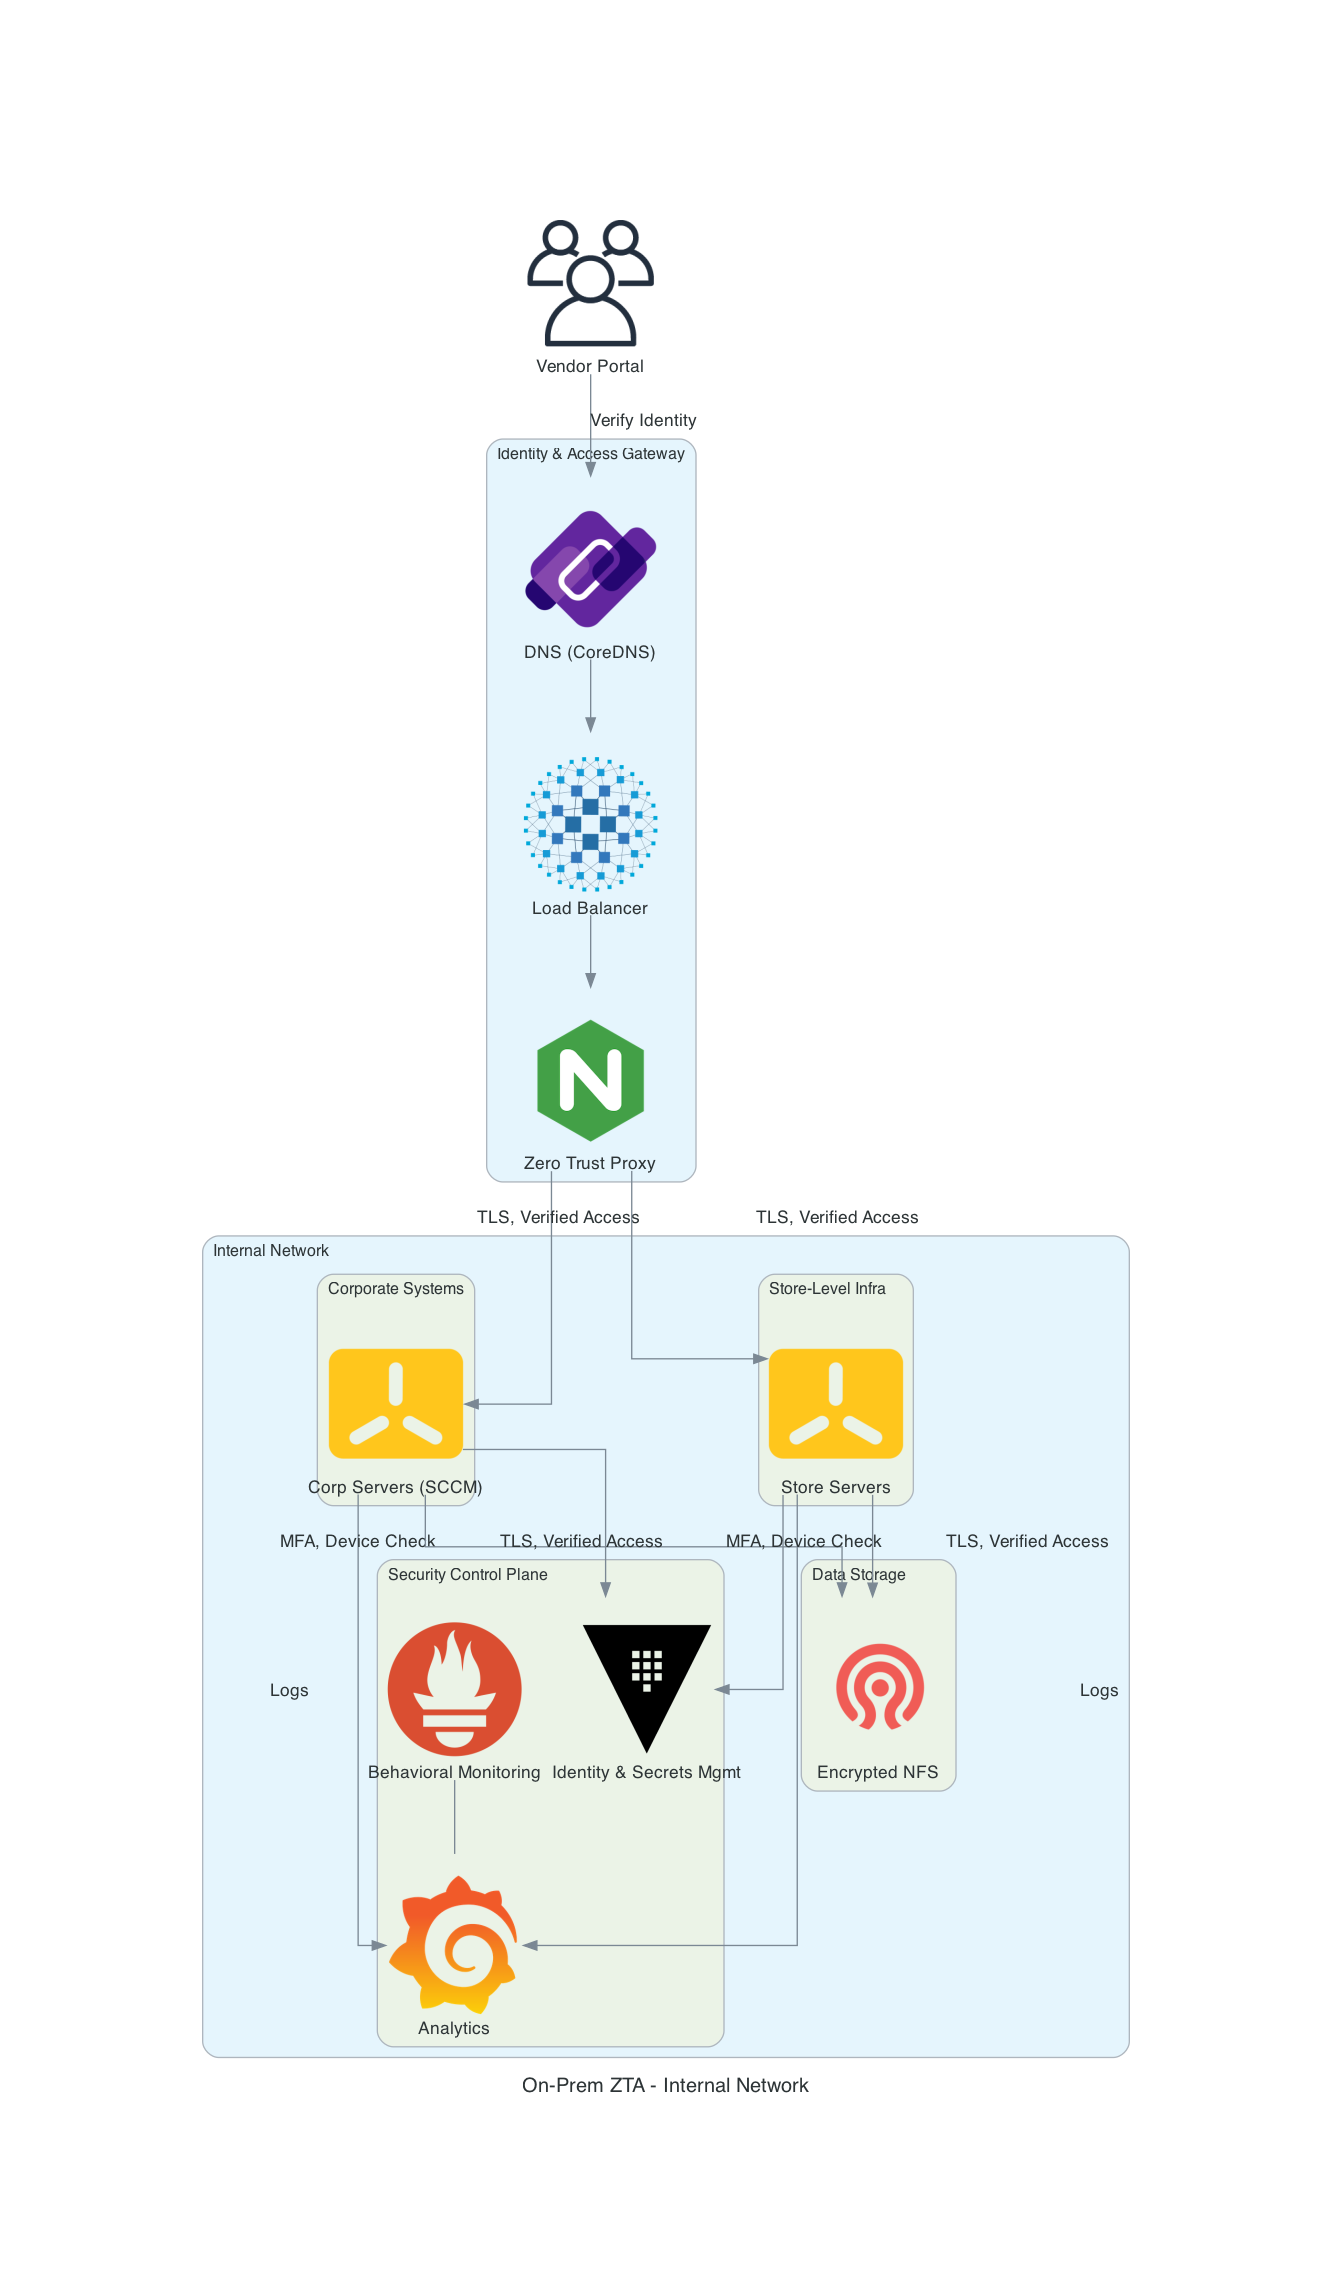

In [26]:
### 2. Zero Trust Architecture (ZTA) - On-Premises for Internal Network

import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem ZTA - Internal Network", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_zta_internal"):

    # External Entities
    vendors = Users("Vendor Portal")

    # Identity & Access Gateway
    with Cluster("Identity & Access Gateway"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer")
        proxy = Nginx("Zero Trust Proxy")
        vendors >> Edge(label="Verify Identity") >> dns >> lb >> proxy

    # Segmented Internal Network
    with Cluster("Internal Network"):
        # Corporate Systems Segment
        with Cluster("Corporate Systems"):
            corp_servers = Kubernetes("Corp Servers (SCCM)")
            proxy >> Edge(label="TLS, Verified Access") >> corp_servers

        # Store-Level Infrastructure Segment
        with Cluster("Store-Level Infra"):
            store_servers = Kubernetes("Store Servers")
            proxy >> Edge(label="TLS, Verified Access") >> store_servers

        # Security Control Plane
        with Cluster("Security Control Plane"):
            vault = Vault("Identity & Secrets Mgmt")
            monitoring = Prometheus("Behavioral Monitoring") - Grafana("Analytics")
            corp_servers >> Edge(label="MFA, Device Check") >> vault
            store_servers >> Edge(label="MFA, Device Check") >> vault
            corp_servers >> Edge(label="Logs") >> monitoring
            store_servers >> Edge(label="Logs") >> monitoring

        # Data Storage Segment
        with Cluster("Data Storage"):
            nfs = NetworkFileSystem("Encrypted NFS")
            corp_servers >> Edge(label="TLS, Verified Access") >> nfs
            store_servers >> Edge(label="TLS, Verified Access") >> nfs

# Display in Jupyter
image_path = "cyberarch/onprem_zta_internal.png"
display(Image(filename=image_path))


#### Issue-3: **Point-of-Sale (POS) Systems**
- **Description**: Target’s POS systems were deployed across nearly 1,800 U.S. stores. These systems processed customer transactions, reading credit and debit card data from magnetic stripes (pre-EMV chip adoption) as cards were swiped.
- **Role in Breach**: The attackers installed malware, known as Trojan.POSRAM or BlackPOS, on the POS devices. This “RAM-scraping” malware captured unencrypted card data from the memory of the POS terminals during transactions and stored it temporarily before exfiltration.
- **Vulnerability**: The POS systems were not adequately isolated from the rest of the network, and card data was unencrypted in memory during processing, making it accessible to the malware. Weak access controls and outdated security patches further exposed these devices.

#### Zero Trust Architecture (ZTA) - On-Premises
**Goal**: Enforce continuous verification within the internal network.

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Identity Verification & MFA  | Gateway to all segments (Proxy, Vault)           | Ensures authenticated access; prevents lateral movement (e.g., Target’s vendor breach).               |
| 2. Microsegmentation            | Corporate, Store, and Data segments              | Isolates resources; requires re-verification (e.g., unlike Target’s unrestricted access).             |
| 3. Behavioral Monitoring & Analytics | All segments (Prometheus, Grafana)              | Detects anomalies across segments; prevents undetected escalation.                                    |
| 4. Encrypted Communication      | TLS between segments (Proxy→Corp, Corp→NFS)     | Secures data; prevents interception during internal traversal.                                        |
| 5. Least Privilege Access Policies | Vault for all segment access                    | Limits permissions; stops broad network access (e.g., Target’s segmentation failure).                 |



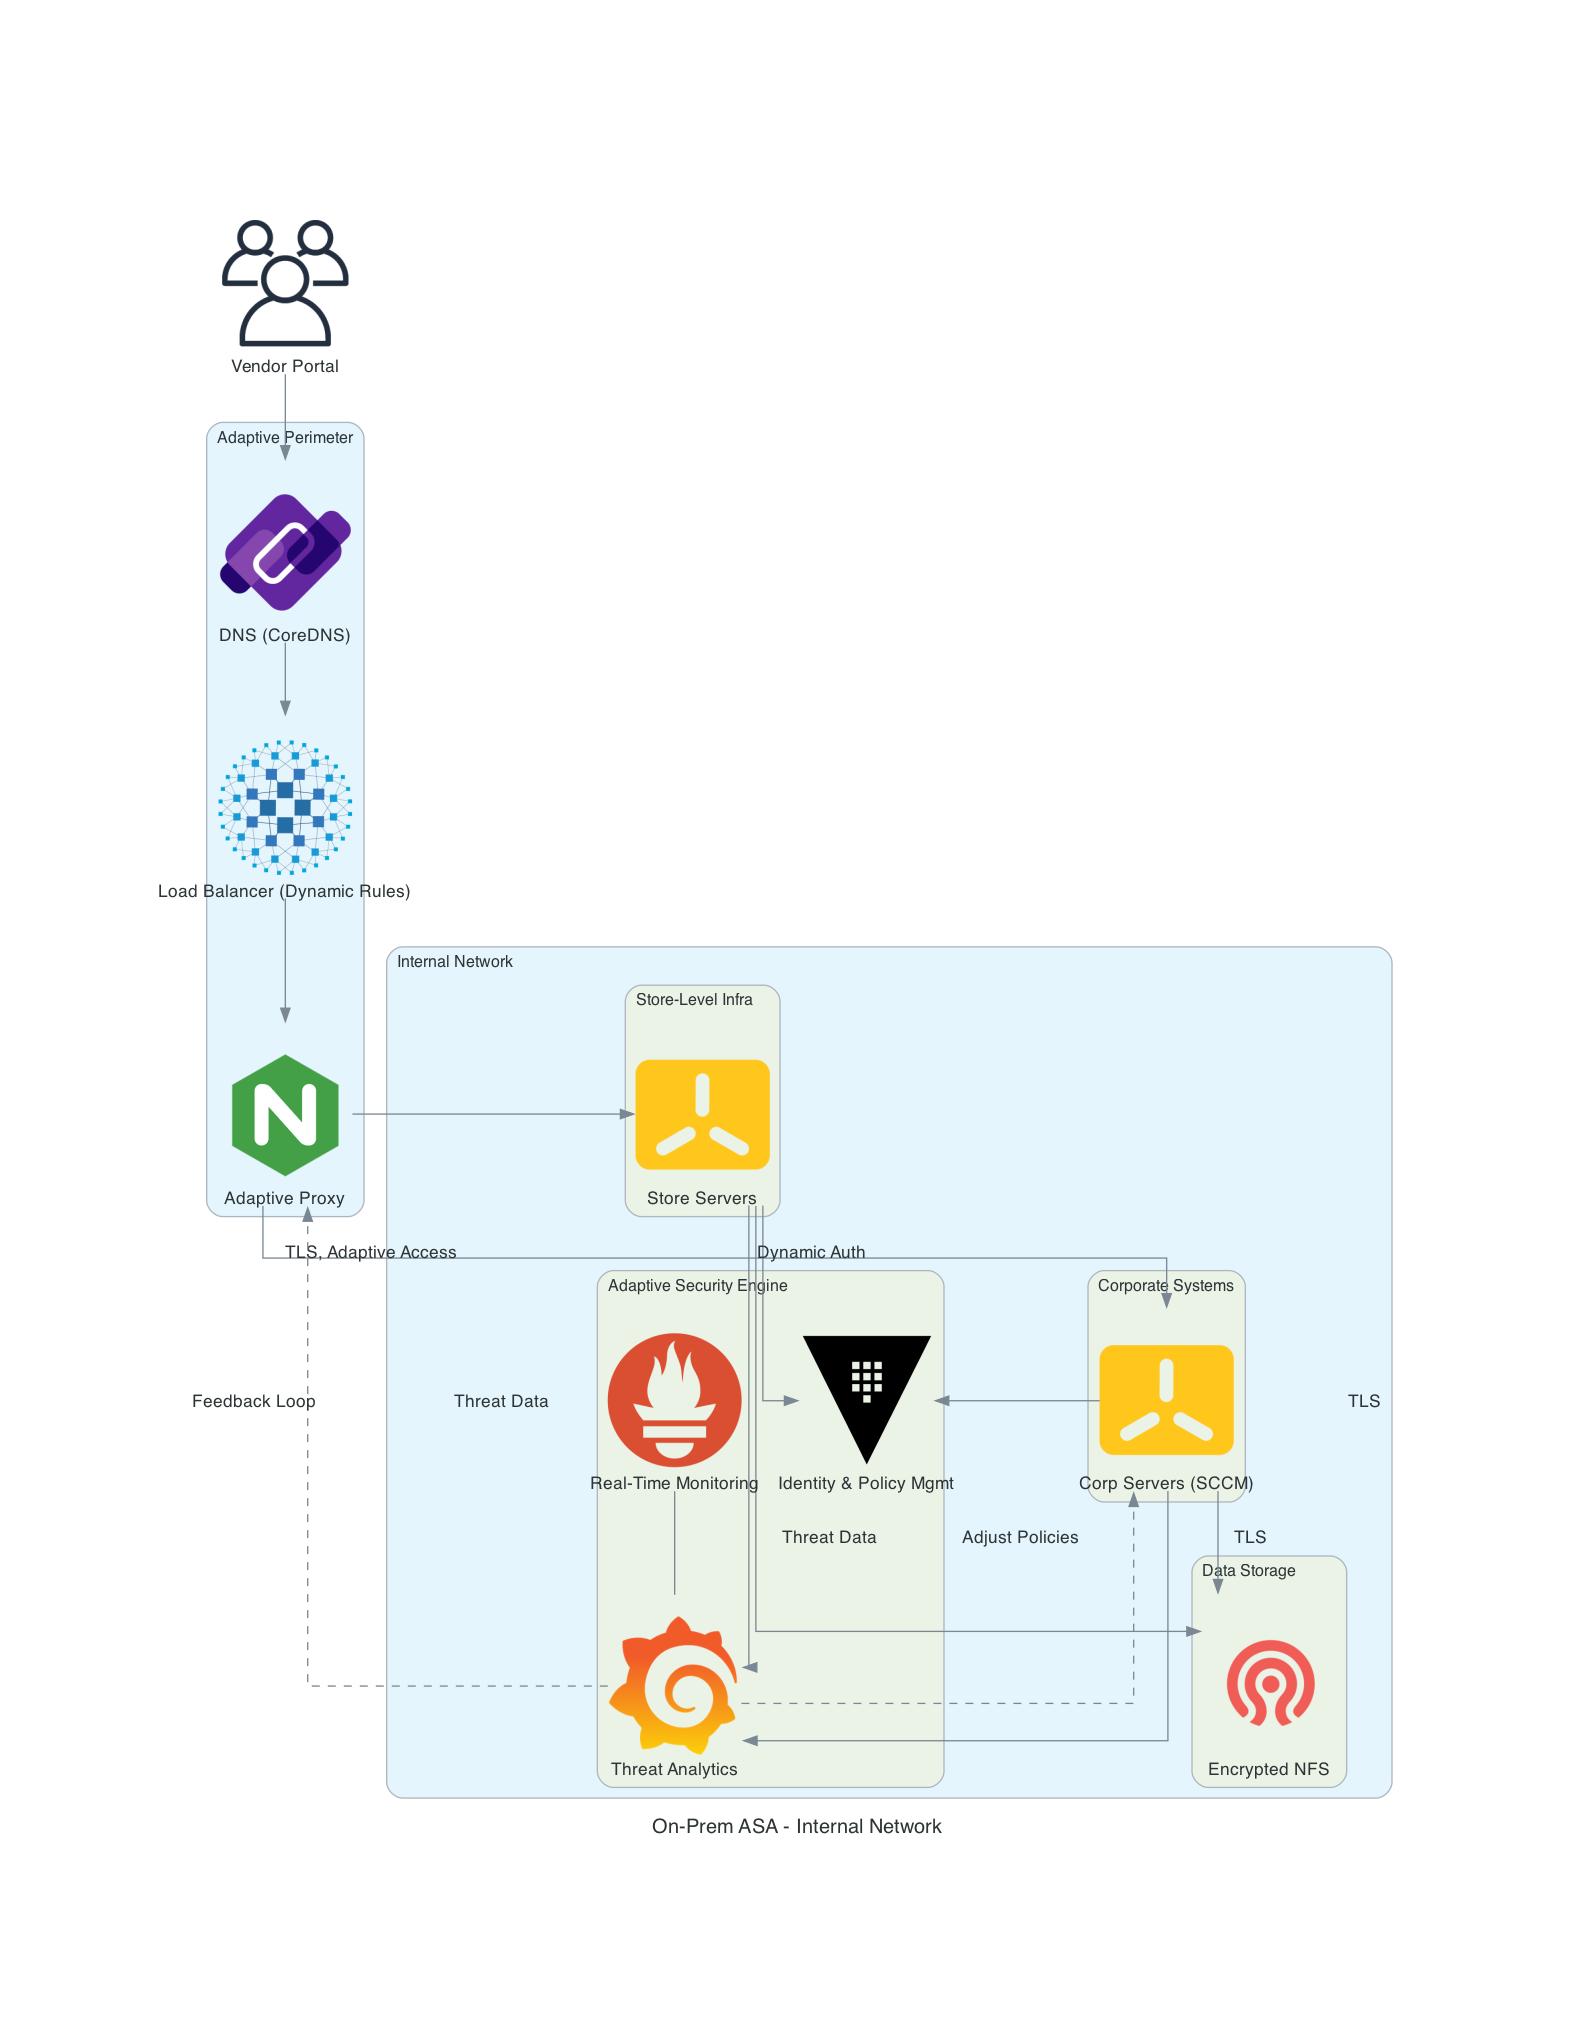

In [28]:
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Haproxy, Nginx
from diagrams.onprem.dns import Coredns
from diagrams.onprem.storage import CEPH as NetworkFileSystem
from diagrams.onprem.container import K3S as Kubernetes
from diagrams.onprem.monitoring import Prometheus, Grafana
from diagrams.onprem.security import Vault
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Define the diagram
with Diagram("On-Prem ASA - Internal Network", show=False, direction="TB", outformat="png", filename="cyberarch/onprem_asa_internal"):

    # External Entities
    vendors = Users("Vendor Portal")

    # Adaptive Perimeter
    with Cluster("Adaptive Perimeter"):
        dns = Coredns("DNS (CoreDNS)")
        lb = Haproxy("Load Balancer (Dynamic Rules)")
        proxy = Nginx("Adaptive Proxy")
        vendors >> dns >> lb >> proxy

    # Segmented Internal Network
    with Cluster("Internal Network"):
        # Corporate Systems Segment
        with Cluster("Corporate Systems"):
            corp_servers = Kubernetes("Corp Servers (SCCM)")
            proxy >> Edge(label="TLS, Adaptive Access") >> corp_servers

        # Store-Level Infrastructure Segment
        with Cluster("Store-Level Infra"):
            store_servers = Kubernetes("Store Servers")
            proxy >> Edge(label="TLS, Adaptive Access") >> store_servers

        # Adaptive Security Engine
        with Cluster("Adaptive Security Engine"):
            vault = Vault("Identity & Policy Mgmt")
            monitoring = Prometheus("Real-Time Monitoring") - Grafana("Threat Analytics")
            corp_servers >> Edge(label="Dynamic Auth") >> vault
            store_servers >> Edge(label="Dynamic Auth") >> vault
            corp_servers >> Edge(label="Threat Data") >> monitoring
            store_servers >> Edge(label="Threat Data") >> monitoring
            monitoring >> Edge(label="Feedback Loop", style="dashed") >> proxy

        # Data Storage Segment
        with Cluster("Data Storage"):
            nfs = NetworkFileSystem("Encrypted NFS")
            corp_servers >> Edge(label="TLS") >> nfs
            store_servers >> Edge(label="TLS") >> nfs
            monitoring >> Edge(label="Adjust Policies", style="dashed") >> corp_servers

# Display in Jupyter
image_path = "cyberarch/onprem_asa_internal.png"
display(Image(filename=image_path))


#### Adaptive Security Architecture (ASA) - On-Premises
**Goal**: Dynamically adapt internal network security to threats.

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Dynamic Threat Filtering     | Adaptive Perimeter (Haproxy, Nginx Proxy)        | Adjusts rules to block lateral threats; prevents vendor-to-internal escalation (e.g., Target).        |
| 2. Behavioral Analytics         | All segments (Prometheus, Grafana)               | Detects anomalies across network; prevents prolonged breaches (e.g., Target’s POS access).            |
| 3. Automated Policy Updates     | Vault, Kubernetes across segments                | Dynamically tightens access; mitigates segmentation flaws (e.g., Target’s unrestricted movement).     |
| 4. Encrypted Data Channels      | TLS between segments (Proxy→Corp, Corp→NFS)     | Protects data; adapts encryption to threat context.                                                  |
| 5. Continuous Monitoring & Feedback | All tiers (Monitoring)                          | Adjusts defenses in real-time; prevents exploitation from poor segmentation.                          |



#### Issue-3: Data Staging Servers
- **Description**: Within Target’s internal network, the attackers compromised three internal servers to act as staging points or “dump servers” for collecting stolen data.
- **Role in Breach**: The malware on the POS systems transmitted captured card data to these servers. The attackers then used these servers to aggregate the data before moving it out of the network.
- **Vulnerability**: The servers were accessible due to weak authentication (e.g., easily guessable passwords like “BackuPuser” or “Best1_user”) and lacked sufficient monitoring to detect unusual activity.

#### Issue-4: Exfiltration Pathway
- **Description**: The attackers established a pathway to move stolen data out of Target’s network to external servers under their control, often located in Russia or other regions.
- **Role in Breach**: Data was exfiltrated periodically from the dump servers to external FTP servers using protocols like FTP or ICMP packets to signal remote operators. The stolen data was then sold on black-market forums.
- **Vulnerability**: Target’s network lacked robust egress filtering and real-time monitoring to detect and block the outbound transfer of large volumes of sensitive data.